# Linear Regression at lat 30, 30.7, 31.4 and 32 °N

#### To save files into netcdfs of linear regressed data

In [6]:
import pandas as pd
import numpy as np
from MITgcmutils import rdmds
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmocean
import scipy.signal as sig
import scipy.io as sio
import scipy.interpolate as sciint
import seaborn as sns
import pylab as pl
import xarray as xr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import ffmpeg
from math import radians, cos, sin, asin, sqrt
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Getting the values 

In [1]:
def get_Brink(file_fig):#,file_h): #, file_ratio):
    # Brink mode
    file = sio.loadmat(file_fig)
    z, xpl, xxx, zzz, xgr, zgr = file['z'][0,:], file['xpl'][0,:], file['xxx'][0,:], file['zzz'][0,:], file['xgr'], file['zgr']
    k, omega,epe,eke = file['wavenumber'][0][0], file['frequency'][0][0], file['epe'][0][0],file['eke'][0][0]

    # (u is cross-shore and v is alongshore in Brink.)
    p0, u0, v0, w0, r0 = file['p'], file['u'],file['v'], file['wvel'], file['rho']

    #file_rfw = sio.loadmat(file_ratio)
    #R = file_rfw['ratio_for_wave'][0][0]
    #print('ratio for wave', R)
    #print('k (rad/cm) ', k)
    #print('lambda (km) ', ((2*np.pi)/(k*100))*1E-3)
    #print('omega (rad/s) ', omega)
    #print('period (days)', ((2*np.pi)/omega)/(3600*24))
    #print('c (m/s)', (omega/(k*100)))
    scale=0.2
    w = w0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization (?)
    u = u0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization 
    v = v0.transpose() * 0.01 * scale # cms-1 to ms-1 and normalization 
    r = r0.transpose() * 1.0 * scale # mg/cm³ to kg/m³ and normalization
    p = p0.transpose() * 0.1 * scale # dyn/cm² to 0.1 Pa (or kg m-1 s-2) and normalization
    
   # hfile=sio.loadmat(file_h)
    #h=hfile['h']
    
    #nn=np.size(h)+2
    #mm=np.size(h)+2
    #xgr = np.zeros((nn-2,mm-2))
    #zgr =  np.zeros((nn-2,mm-2))
    #xmax=max(xpl)
    #xmax = xmax*1.0e05
    #dt = 1/(mm-3)
    #dx = xmax/(nn-3)
    #for n in np.arange(0,nn-2,1):
     #   xtemp = dx*n
      #  xgr[n,:] = (xtemp*np.ones(mm-2))/1e5
       # zgr[n,:] = h[0,n]*(-1+dt*np.arange(0,mm-2,1))/100
    
    #z[0:-1]=-np.log10(-z[0:-1])
    #zzz=-np.log10(-zzz)
    
    return(u,v,w,r,p,z,k,omega,xpl, xxx, zzz,zgr.transpose(),xgr.transpose(), epe, eke)

def loadNetCDFs(varname):
    dsw=[]
    dsn=[]
    for i in np.arange(0,8,1):
        
        if varname=='DYNVARS':
            pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
            pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        else:
            pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01b_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
            pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01b_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        
        dswin  = xr.open_dataset(pathw)
        dsnin = xr.open_dataset(pathn)
        
        dsw.append(dswin)
        dsn.append(dsnin)
        
    return dsw, dsn

## Plot

In [54]:
def LINREGplot(fig,VALMITp,VALFITp,VALbrink,dsw,ind,lat,grid_Z,grid_X,dist,Z,TIME,BETAp,FITp,t,rmse):
    
    xlab='Crosshore distance [km]'
    ylab='Depth [m]'
    modes=len(VALbrink[:,1,1])
    
    fig = plt.figure(tight_layout=True)
    if modes<=4:
        gs = GridSpec(nrows=4, ncols=2, height_ratios=[1.5,1,1,1])
    elif modes<=6:
        gs = GridSpec(nrows=5, ncols=2, height_ratios=[1.5,1,1,1,1])
    elif modes<=8:
        gs = GridSpec(nrows=6, ncols=2, height_ratios=[1.5,1,1,1,1,1])        
    #depths=np.arange(75,-1,-1)
    vmin=-np.nanmax(abs(VALMITp[t,:,:]))
    vmax=np.nanmax(abs(VALMITp[t,:,:]))

    levels=np.linspace(vmin,vmax,15)

    vminb=-np.nanmax(abs(VALbrink))
    vmaxb=np.nanmax(abs(VALbrink))

    levelsb=np.linspace(vminb,vmaxb,15)
    
    
    hFacC = dsw[0].hFacC
    hfac = np.ma.masked_values(hFacC, 0)
    mask = np.ma.getmask(hfac)
    coast=np.where(mask[0,ind,:]==False)

    LON = dsw[0].XC[coast]-360

    distance=cos((lat*np.pi)/180)*111*-1*(LON-LON[-1])
    
    indlonpre=np.where(distance<=99)
        
    indlon=np.flip(indlonpre[0])
    vminr=-np.nanmax(abs(VALMITp[t,:,:]-VALFITp[t,:,:] ))
    vmaxr=np.nanmax(abs(VALMITp[t,:,:]-VALFITp[t,:,:] ))

    levelsr=np.linspace(vminr,vmaxr,15)
    
    ax6 = fig.add_subplot(gs[0, :])
    ax6.set_facecolor('tan')
    cax3=ax6.contourf(grid_X,grid_Z,VALMITp[t,:,:]-VALFITp[t,:,:] ,cmap=cmocean.cm.delta,levels=levelsr)
    ax6.contour(grid_X,grid_Z,VALMITp[t,:,:]-VALFITp[t,:,:] , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax6.set(xlabel=xlab, ylabel=ylab)
    ax6.set_title('Residuals') 

    ax0 = fig.add_subplot(gs[1, 0])
    ax0.set_facecolor('tan')
    cax1=ax0.contourf(grid_X,grid_Z,VALFITp[t,:,:] ,cmap=cmocean.cm.delta,levels=levels)
    ax0.contour(grid_X,grid_Z,VALFITp[t,:,:] , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax0.set(xlabel=xlab, ylabel=ylab)
    ax0.set_title('Linear regression fit')
   
    
    ax1 = fig.add_subplot(gs[1, 1])
    ax1.set_facecolor('tan')
    ax1.contourf(grid_X,grid_Z,VALMITp[t,:,:] ,cmap=cmocean.cm.delta,levels=levels)
    ax1.contour(grid_X,grid_Z,VALMITp[t,:,:] , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax1.set(xlabel=xlab, ylabel=ylab)
    ax1.set_title('MITgcm')
    
    for i in np.arange(0,modes,1):
        if i<=1:
            ax = fig.add_subplot(gs[2, i])
        elif i<=3:
            ax = fig.add_subplot(gs[3, i-2])
        elif i<=5:
            ax = fig.add_subplot(gs[4, i-4])
        elif i<=7:
            ax = fig.add_subplot(gs[5, i-6])
        cax2=plotbrink(ax,grid_X,grid_Z,levelsb,xlab,ylab,i,VALbrink[i])
    
    

    cbar_ax = fig.add_axes([1, 0.48, 0.03, 0.14])
    fig.colorbar(cax1, cax=cbar_ax)
    cbar_ax.set_ylabel('Pressure')
    cbar_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    
    cbar_ax2 = fig.add_axes([1, 0.08, 0.03, 0.3])
    fig.colorbar(cax2, cax=cbar_ax2)
    cbar_ax2.set_ylabel('Pressure')
    cbar_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    
    cbar_ax3 = fig.add_axes([1, 0.72, 0.03, 0.14])
    fig.colorbar(cax3, cax=cbar_ax3)
    cbar_ax3.set_ylabel('Residuals')
    cbar_ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    
    if np.isnan(VALMITp[t]).any()==True:
        val=VALMITp[t]
        valf=VALFITp[t]
        std=np.std(val[~np.isnan(val)]-valf[~np.isnan(val)])
    else:
        std=np.std(VALMITp[t,:,:]-VALFITp[t,:,:])
    func=f'Regression line: Y = {BETAp[t,0]:.2e}'
    for i in np.arange(len(BETAp[t])-1):
            func += f'+ {BETAp[t,i+1]:.2e}X {i+1}'
    fig.suptitle(func + f'\n At {lat}°N. After {TIME[t]/(60*24):.1f} days. STD: {std:.2e}. RMSE:{rmse:.3e} ')
    #fig.tight_layout()

def plotbrink(ax,grid_X,grid_Z,levelsb,xlab,ylab,nr,varbrink):
    ax.set_facecolor('tan')
    cax=ax.contourf(grid_X,grid_Z,varbrink ,cmap=cmocean.cm.delta,levels=levelsb)
    ax.contour(grid_X,grid_Z,varbrink , levels=[0], linewidths=2, 
                linestyles='-', colors='k', zorder=2)
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.set_title(f'Mode {nr+1}')
    
    return cax

## Interpolation function

In [3]:
def interpolate(VALmit,brinkvals,dist,xpl,Z,z,zgr,xgr,indlon,mask):
    
    modes=len(brinkvals[:,0,0])
    
    #finding the coordinates for all points in the brink variable
    zpib,xpib=np.where(brinkvals[0,:,:]<100)
    zpim,xpim=np.where(mask[:,indlon]==False)
    
    #picking out the values using the coordinates and creating a 1D vector
    brinkvals1d=np.zeros((modes,len(zpib)))
    
    for i in np.arange(0,modes,1):
        brinkvals1d[i,:]=brinkvals[i,zpib,xpib]
    
    valmitin=VALmit[zpim,xpim]
    
    # go back to 2D
    # valmit2d = np.zeros(np.shape(VALmit))
    #for i in np.arange(len(valmitout)):
    #    valmit2d[zpi[i],xpi[i]]=valmitout[i]
    
    
    #Creating a grid of Z which does not include the values in the coast, similar to the grid from Brink
    grid_Z=np.zeros(np.shape(VALmit))
    for i in np.arange(0,len(indlon),1):

        coastz=np.where(mask[:,indlon[i]]==False) #finding the indices of the coast at one x-location
        if len(Z[coastz])>0:
            places=np.arange(0,len(Z),len(Z)/len(Z[coastz]))  #creating a vector of the same size as how many 
            #depth values we have that aren't the coast 
            if len(places)> len(Z[coastz]):           #Sometimes the vector became too long
                places=places[:-1] 
            places[-1]=len(Z)                   #making sure the last value in the vector of indices 
            #is 71 so we interpolate over the same start and finish vaues
            grid_Z[:,i]=np.interp(np.arange(0,len(Z),1),places,Z[coastz]) #Interpolating the values that arent the coast
            # to agree with the amount of depth values the
                        
                                                                  # the model outputs. Using the range of indices
                                                                  #given from the vector created to show indices
                                                                  # that the depth values not on the coast correspond to
                                                                  # and then fillign the rest with values between these.

    #Creating a grid of the x-values, which are the same for every Z
    grid_X,grid_no = np.meshgrid(dist,Z)
    
    
    points=[zgr[zpib,xpib],xgr[zpib,xpib]] #find the depth and distance for each of the indices in the Brink code
    points=np.asarray(points).transpose()  #transposing this to so the values are the columns and not the rows for the interpolation
    
    brinkvalsout=np.zeros((modes,len(grid_Z[:,0]),len(grid_Z[0,:])))
    
    for i in np.arange(0,modes,1):
        brinkvalsout[i,:,:] = sciint.griddata(points,  brinkvals1d[i,:], (grid_Z, grid_X), method='linear')
    
    
    pointsMIT=[grid_no[zpim,xpim],grid_X[zpim,xpim]] 
    pointsMIT=np.asarray(pointsMIT).transpose() 
    
    valmitint = sciint.griddata(pointsMIT, valmitin, (grid_Z, grid_X), method='linear')
    
    if np.isnan(valmitint).any() ==True:
        zpi,xpi=np.where( ~np.isnan(valmitint))
    else: 
        zpi,xpi=np.where( ~np.isnan(brinkvalsout[0,:,:]))
        
    valmit1d= valmitint[zpi,xpi]
    #zpi,xpi=np.where(~np.isnan(valbrinkout1))
    brinkvalsout1d=np.zeros((modes,len(valmit1d)))
    
    for i in np.arange(0,modes,1):
        brinkvalsout1d[i,:]=brinkvalsout[i,zpi,xpi]

    
    
    return valmit1d,brinkvalsout1d,xpi,zpi,brinkvalsout,grid_X,grid_Z,xpi,valmitint

## Ordinary least square regression

In [4]:
def lin_reg(VALmit,brinkvals,dist,xpl,Z,z,zgr,xgr,indlon,maskin):

    Ypre,brinkvalsout1d,xpi,zpi,brinkvalsout,grid_X,grid_Z,xpi,valmitint=interpolate(VALmit,brinkvals,dist,xpl,
                                                                              Z,z,zgr,xgr,indlon,maskin)
    Y=Ypre-np.mean(Ypre)
    X=np.vstack((np.ones(len(brinkvalsout1d[1,:])),brinkvalsout1d)).T
    beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
    
    yhat=X.dot(beta_hat) +np.mean(Ypre)
    valout = np.zeros(np.shape(valmitint))

    for i in np.arange(len(Y)):
        valout[zpi[i],xpi[i]]=yhat[i]
    
    
    return beta_hat,yhat,X,valout,brinkvalsout,grid_X,grid_Z,Y,xpi,Ypre,valmitint

def fitmodes(dsw,VALIN,tt,brinkvals,xpl,Z,z,ind,lon,zgr,xgr,filt):
    
    
    hFacC = dsw[0].hFacC
    hfac = np.ma.masked_values(hFacC, 0)
    mask = np.ma.getmask(hfac)
    
    coast=np.where(mask[0,ind,:]==False)
    
    LON = dsw[0].XC[coast]-360

    distance=cos((lat*np.pi)/180)*111*-1*(LON-LON[-1])
    if lat>32:
        indlonpre=np.where(distance<=80)
    else:
        indlonpre=np.where(distance<=99)
    indlon=np.flip(indlonpre[0])
    #actual distance from the coast
    distpre=distance[indlon]
    dist=distpre
    
    modes=len(brinkvals[:,1,1])
    
    maskin=mask[:,ind,:]
    
    VALMIT=np.zeros((len(VALIN[:,1,1]),len(Z),len(dist)))
    VALfit=np.zeros((len(VALIN[:,1,1]),len(Z),len(dist)))
    betas=np.zeros((len(VALIN[:,1,1]),modes+1))
    fit=np.zeros((len(VALIN[:,1,1])))
    RMSE=np.zeros((len(VALIN[:,1,1])))
    for t in np.arange(0,len(VALIN[:,1,1]),1):
        VALmit=VALIN[t,:,:]
        beta_hat,yhat,xbeta,valout,valbrinkout,grid_X,grid_Z,Y,xpi,Ypre,valmitint=lin_reg(VALmit,brinkvals,dist,xpl,Z,z,zgr,xgr,indlon,maskin)
        VALfit[t,:,:]=valout
        betas[t,:]=beta_hat
        VALMIT[t,:,:]=valmitint
            
        mse=np.mean((Ypre - yhat) ** 2)
        rmse=sqrt(mse)
        RMSE[t]=rmse
            
        yi=VALmit
        sst=np.sum((yi-np.mean(yi))**2)
        yihat=valout
        ssr=np.sum((yihat-np.mean(yihat))**2)
        fit[t]=100*(ssr/sst)
        
    
    return VALfit,betas,xbeta,yhat,dist,VALMIT,valbrinkout,grid_X,grid_Z,fit,Y,xpi,Ypre,RMSE,maskin[:,indlon],valmitint


## Calling the functions to perform the linear regression


In [29]:
u,v0,w0,r,p0,z,k0,omega0,xpl, xxx, zzz, zgr, xgr, epe0, eke0= get_Brink('Crossects/dataSVB30.7mode0.mat')
u,v1,w1,r,p1,z,k1,omega1,xpl, xxx, zzz, zgr, xgr, epe1, eke1= get_Brink('Crossects/dataSVB30.7mode1.mat')
u,v2,w2,r,p2,z,k2,omega2,xpl, xxx, zzz, zgr, xgr, epe2, eke2= get_Brink('Crossects/dataSVB30.7mode2.mat')
u,v3,w3,r,p3,z,k3,omega3,xpl, xxx, zzz, zgr, xgr, epe3, eke3= get_Brink('Crossects/dataSVB30.7mode3.mat')
u,v4,w4,r,p4,z,k4,omega4,xpl, xxx, zzz, zgr, xgr, epe4, eke4= get_Brink('Crossects/dataSVB30.7mode4.mat')
u,v5,w5,r,p5,z,k5,omega5,xpl, xxx, zzz, zgr, xgr, epe5, eke5= get_Brink('Crossects/dataSVB30.7mode5.mat')
#u,v6,w6,r,p6,z,k6,omega6,xpl, xxx, zzz, zgr, xgr, epe6, eke6= get_Brink('Crossects/dataSVB32.68mode9.mat')

In [52]:
params = {'font.size': 16,
          'figure.figsize': (15, 15),
         'font.family':'serif'}
pl.rcParams.update(params)

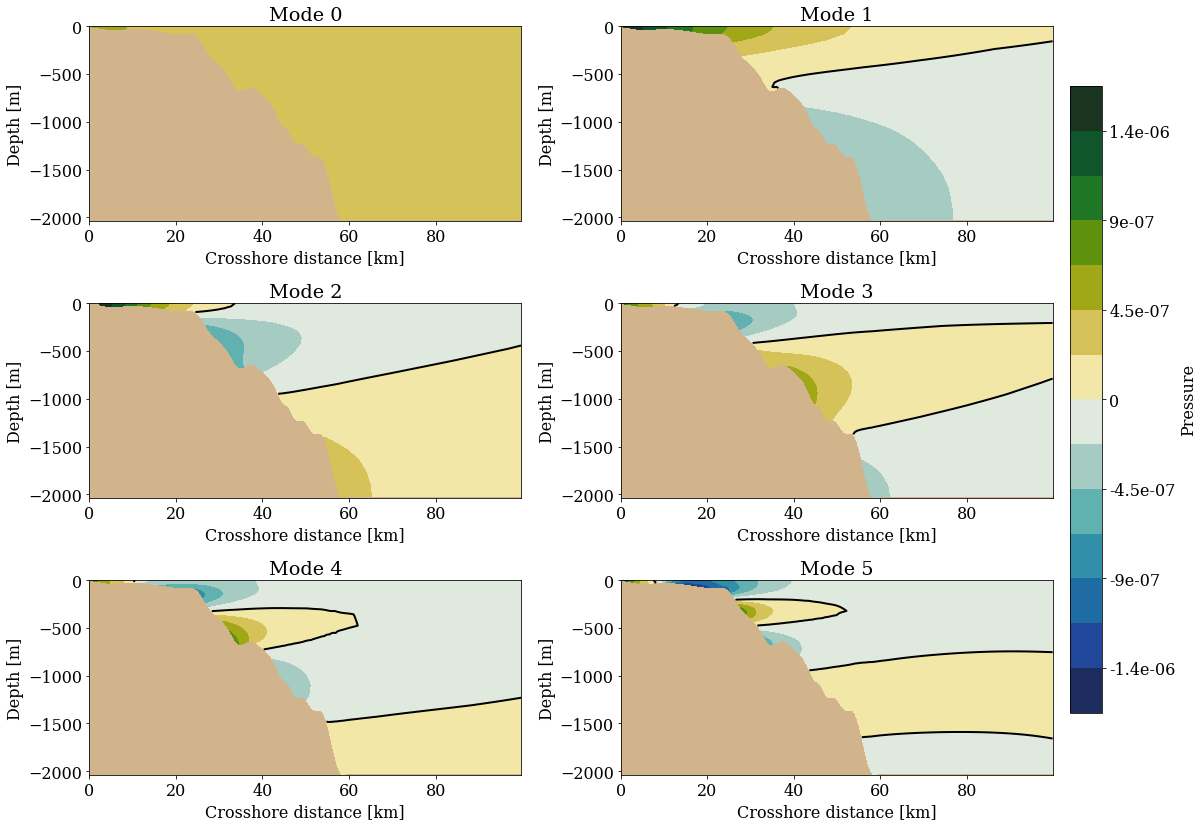

In [55]:
vals=np.array([p0, p1, p2, p3, p4,p5])
eke=np.array([eke0, eke1, eke2, eke3, eke4,eke5])
epe=np.array([epe0, epe1,epe2, epe3, epe4,epe5])
omega=np.array([omega0, omega1,omega2, omega3, omega4,omega5])
k=np.array([k0, k1,k2, k3, k4,k5])

vminb=-np.nanmax(abs(p1))
vmaxb=np.nanmax(abs(p1))

levelsb=np.linspace(vminb,vmaxb,15)

xlab='Crosshore distance [km]'
ylab='Depth [m]'
modes=len(vals[:,1,1])
    
fig = plt.figure(tight_layout=True)
if modes<=4:
    gs = GridSpec(nrows=3, ncols=2, height_ratios=[1,1,1])
elif modes<=6:
    gs = GridSpec(nrows=4, ncols=2, height_ratios=[1,1,1,1])
elif modes<=8:
    gs = GridSpec(nrows=5, ncols=2, height_ratios=[1,1,1,1,1])
    
for i in np.arange(-1,modes-1,1):
        if i<=0:
            ax = fig.add_subplot(gs[0, i+1])
        elif i<=2:
            ax = fig.add_subplot(gs[1, i-1])
        elif i<=4:
            ax = fig.add_subplot(gs[2, i-3])
        elif i<=6:
            ax = fig.add_subplot(gs[3, i-5])
        cax2=plotbrink(ax,xgr,zgr,levelsb,xlab,ylab,i,vals[i+1])

cbar_ax = fig.add_axes([1, 0.33, 0.03, 0.58])
fig.colorbar(cax2, cax=cbar_ax)
cbar_ax.set_ylabel('Pressure')
cbar_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
        
#print(f'period (days) {(2*np.pi)/omega/(3600*24)}')
#print(f'c (m/s) {omega/(k*100)}')
#print(f'R=EKE/EPE {(eke/epe)}')

In [72]:
brinkvals=np.array([p1, p2, p3,p4])

In [84]:
dsfilt=xr.open_dataset('Crossects/PHIHYD3298filt.nc')
ds=xr.open_dataset('Crossects/PHIHYD3298.nc')


In [85]:
timesf=dsfilt.time

In [76]:
dsw,dsn=loadNetCDFs('PHIHYD')

In [77]:
varname='WVEL'
i=1
pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'ACnoSVBdep55'+ str(2+i)+'_'+ str(3+i) +'all.nc'
ds1  = xr.open_dataset(pathn)
lon_ac=ds1.lonAC
lat_ac=ds1.latAC
distac=ds1.x

## Running the regression for the filtered data 

In [86]:
VALin=dsfilt.VALfilt.values # ds.VALmit.values #

In [54]:
np.shape(VALin)

(576, 76, 53)

In [87]:
hej=[58, 85, 205, 227] #use one of these indices to create pressure plots in order: 30.84,31.20,32.68,32.98°N
tt=0
filt=1
ind=lat_ac[227]
lat=32.98#remember that all larger than 32 will be for only 80 km from the coast. 

Z=dsw[0].Zl.values
VALfit,betas,xbeta,yhat,dist,VALmit,valbrinkout,grid_X,grid_Z,fit,Y,xpi,Ypre,RMSE,mask,valmitint=fitmodes(dsw,VALin,tt,brinkvals,xpl,Z,z,ind,lat,zgr,xgr,filt)
  

In [88]:
VALMITp=VALmit
VALFITp=VALfit
FITp=fit
BETAp=betas

<Figure size 3240x2880 with 0 Axes>

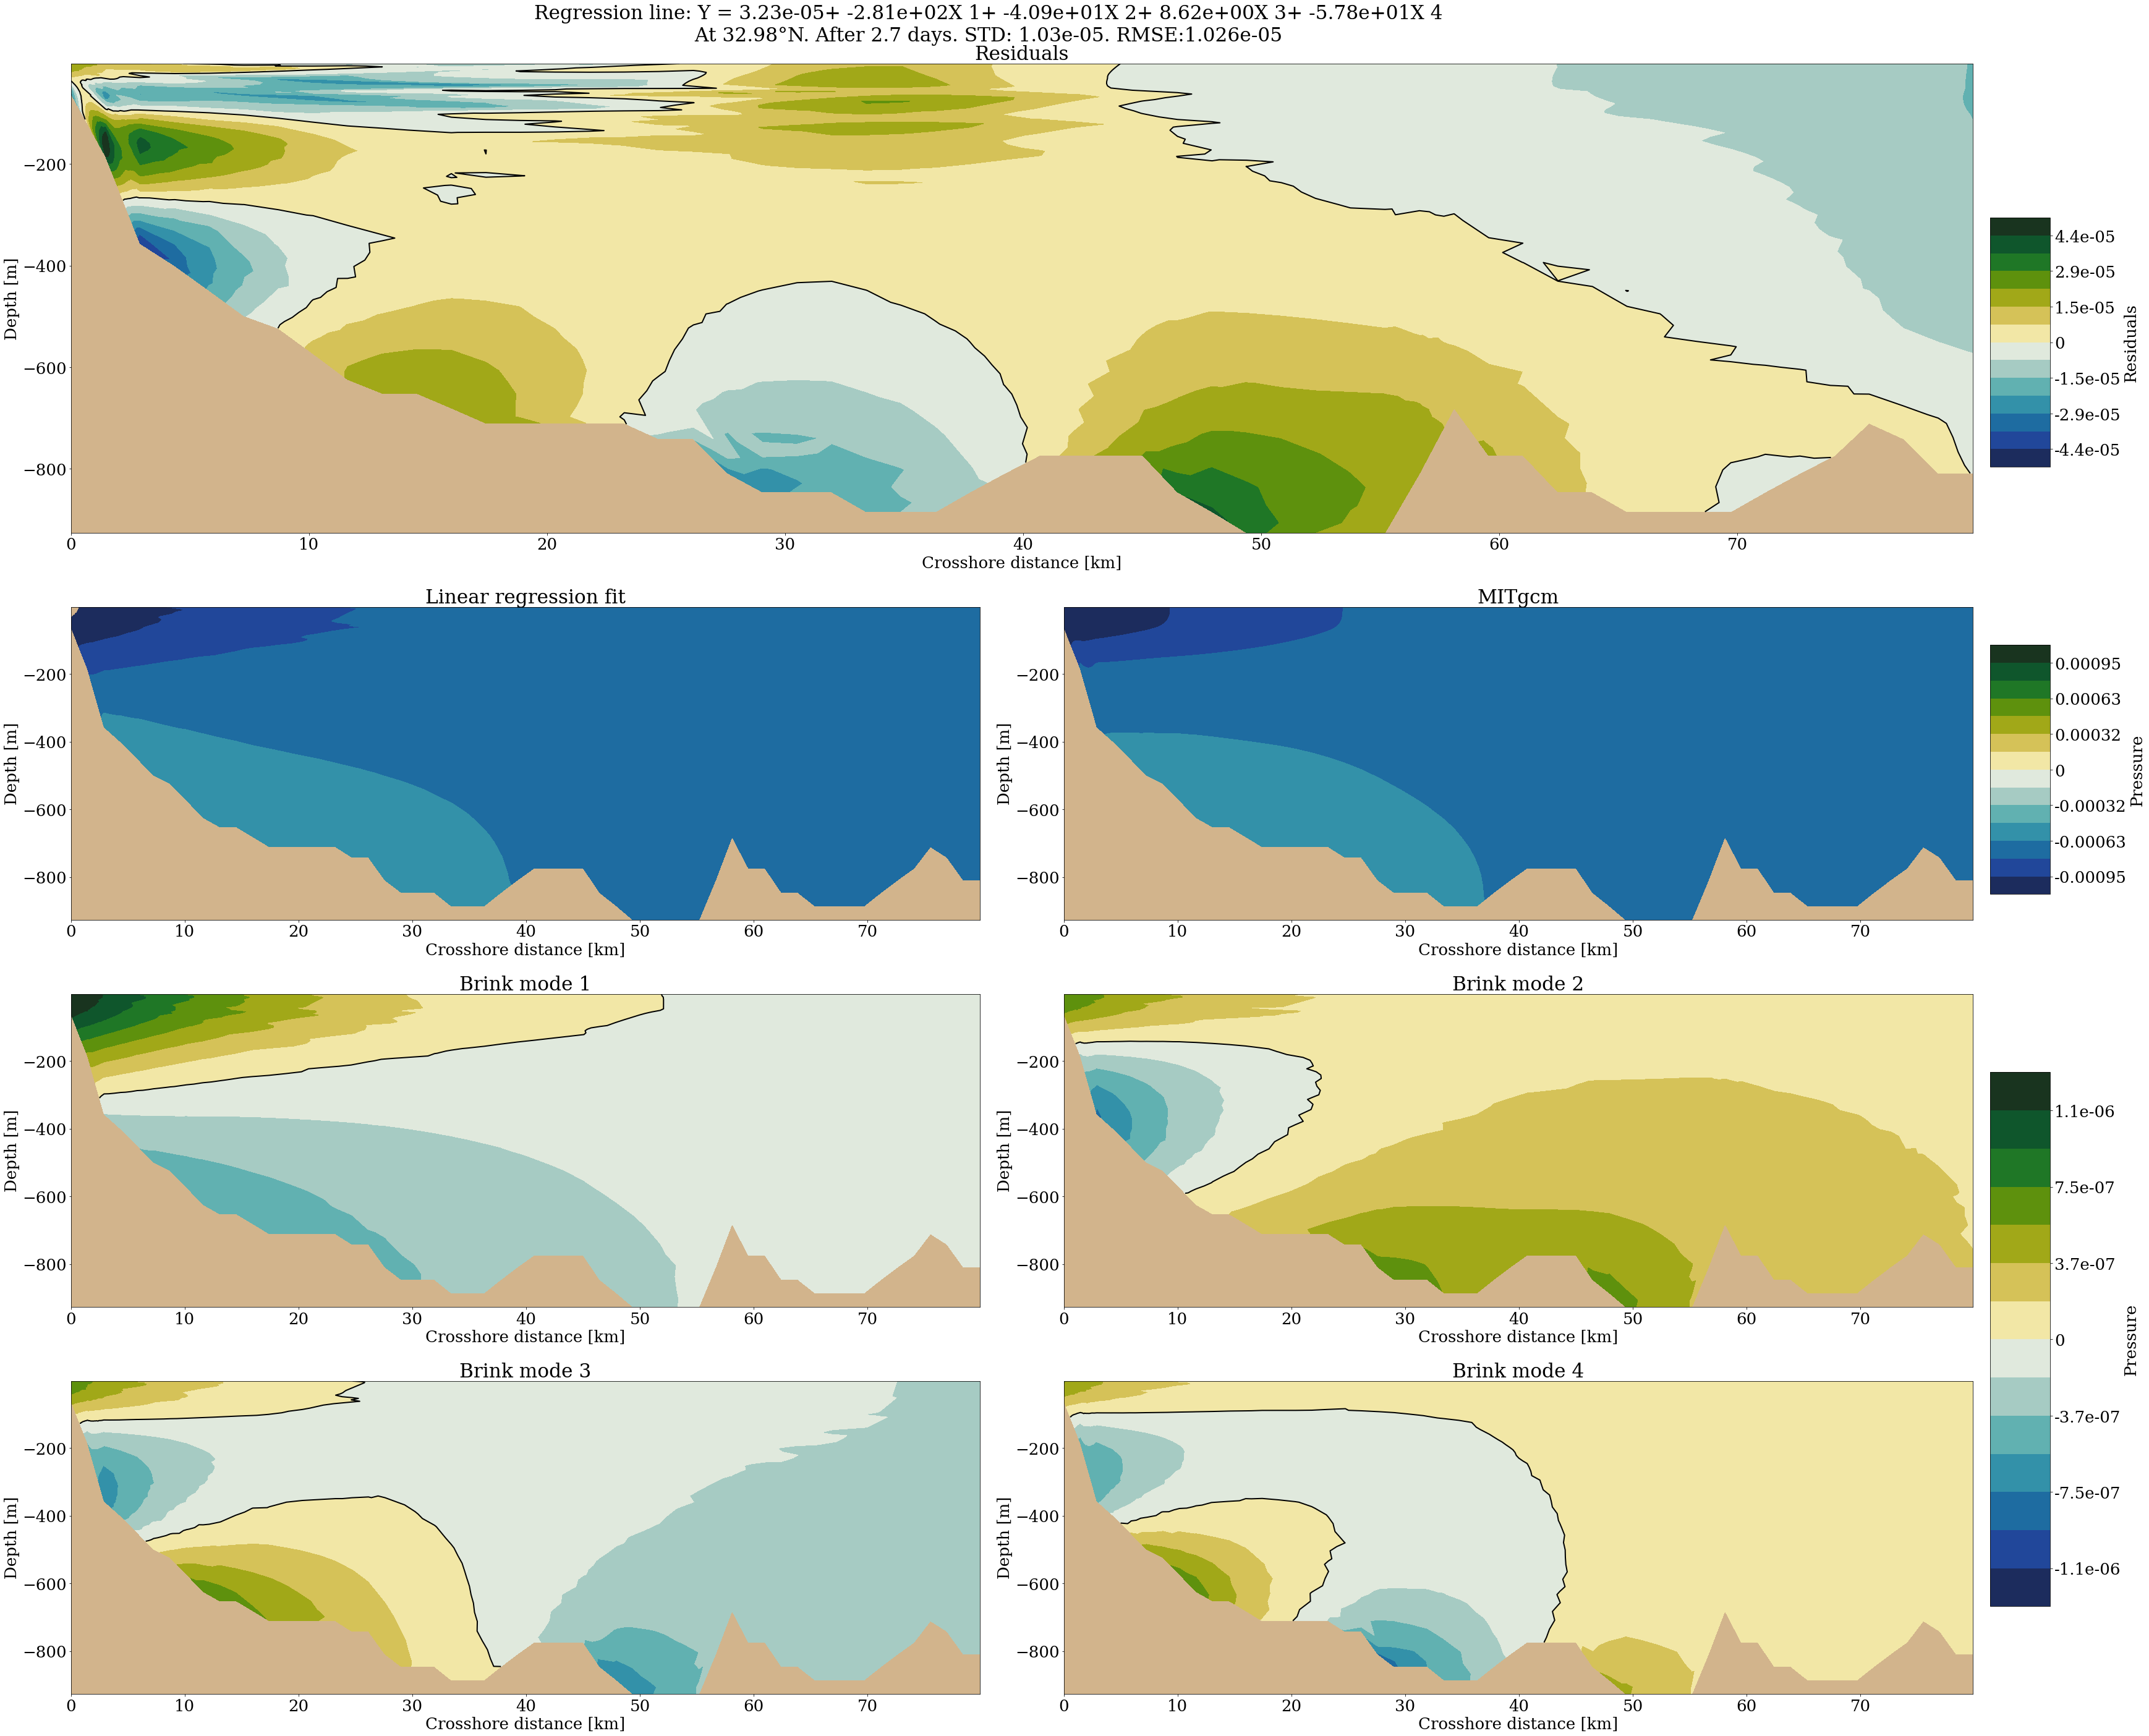

In [93]:
ind=lat_ac[227]
lat=32.98
t=50
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,valbrinkout,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,timesf.values,BETAp,FITp,t,RMSE[t])

## Loading the times

In [59]:
time23=dsw[0].time.values.astype(int)
time34=dsw[1].time.values.astype(int)
time45=dsw[2].time.values.astype(int)
time56=dsw[3].time.values.astype(int)
time67=dsw[4].time.values.astype(int)
time78=dsw[5].time.values.astype(int)
time89=dsw[6].time.values.astype(int)
time910=dsw[7].time.values.astype(int)
    
Time=np.concatenate((time23, time34, time45, time56,time67, time78,time89, time910), axis=0)#, time910), axis=0)
    
times=Time*1e-9
  

## Saving the values

In [94]:
FILENAME='Crossects/LinReg3298FILT.nc'
ds = xr.Dataset({'valfit': (("time","z","x"), VALfit),
                 'valmit': (("time","z","x"), VALmit),
                 'varbrink': (("nrMod","z","x"),valbrinkout),
                 'fit':(("time"), fit),
                 'gridX':(("z","x"), grid_X),
                 'gridZ':(("z","x"), grid_Z),
                 'betas':(("time","nrB"), betas),
                 'rmse':(("time"), RMSE)
                    },
                coords ={
                    "x" : dist.values,
                    "z" : Z,
                    "time": timesf,
                    "nrB": np.arange(0,len(valbrinkout[:,1,1])+1,1),
                    "nrMod":np.arange(0,len(valbrinkout[:,1,1]),1)
                },
                )
ds.to_netcdf(FILENAME)

In [43]:
params = {'font.size': 26,
          'figure.figsize': (20, 10),
         'font.family':'serif'}
pl.rcParams.update(params)

In [66]:
val=VALMITp[600]
valf=VALFITp[600]
np.std(val[~np.isnan(val)]-valf[~np.isnan(val)])

1.3478229616660884e-05

### At 30° N

In [50]:
times[100]

3880.0000000000005

In [57]:
np.where(timesf==times[100])

(array([50]),)

### Filtered 

<Figure size 3240x2880 with 0 Axes>

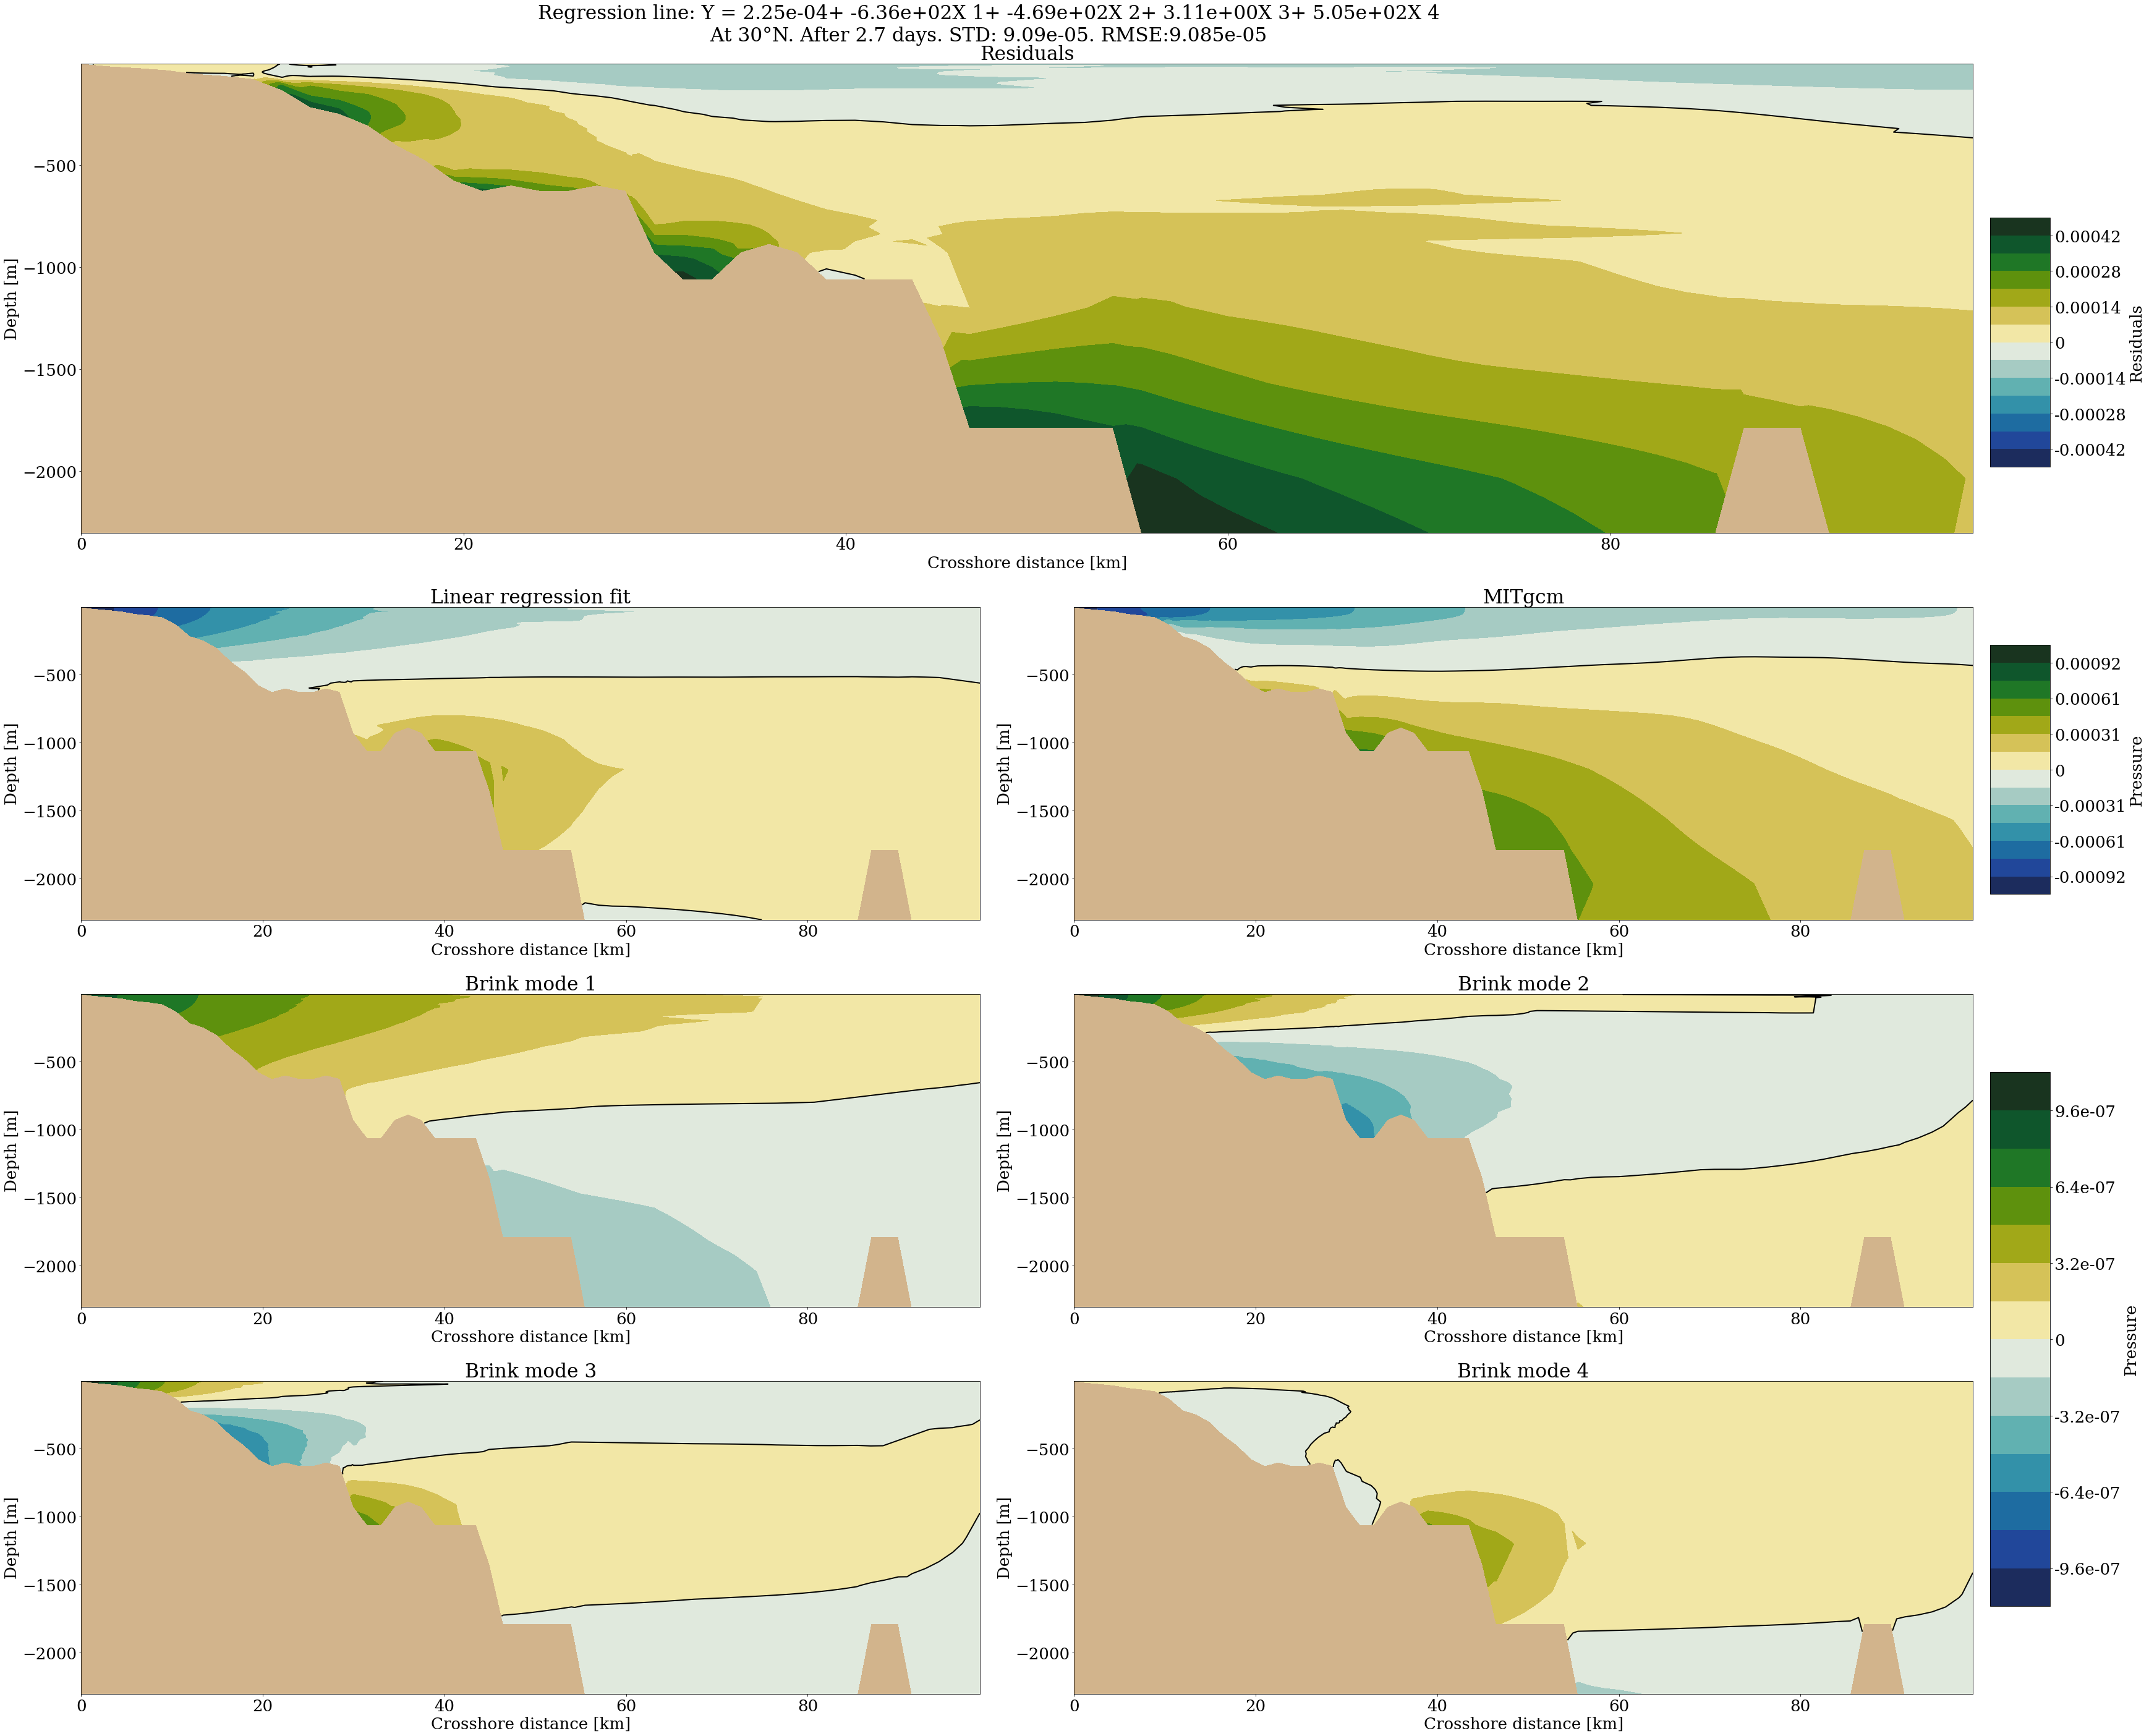

In [209]:
ind=220
lat=30
t=50
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,valbrinkout,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,timesf.values,BETAp,FITp,t,RMSE[t])

### Unfiltered 

<Figure size 3240x2880 with 0 Axes>

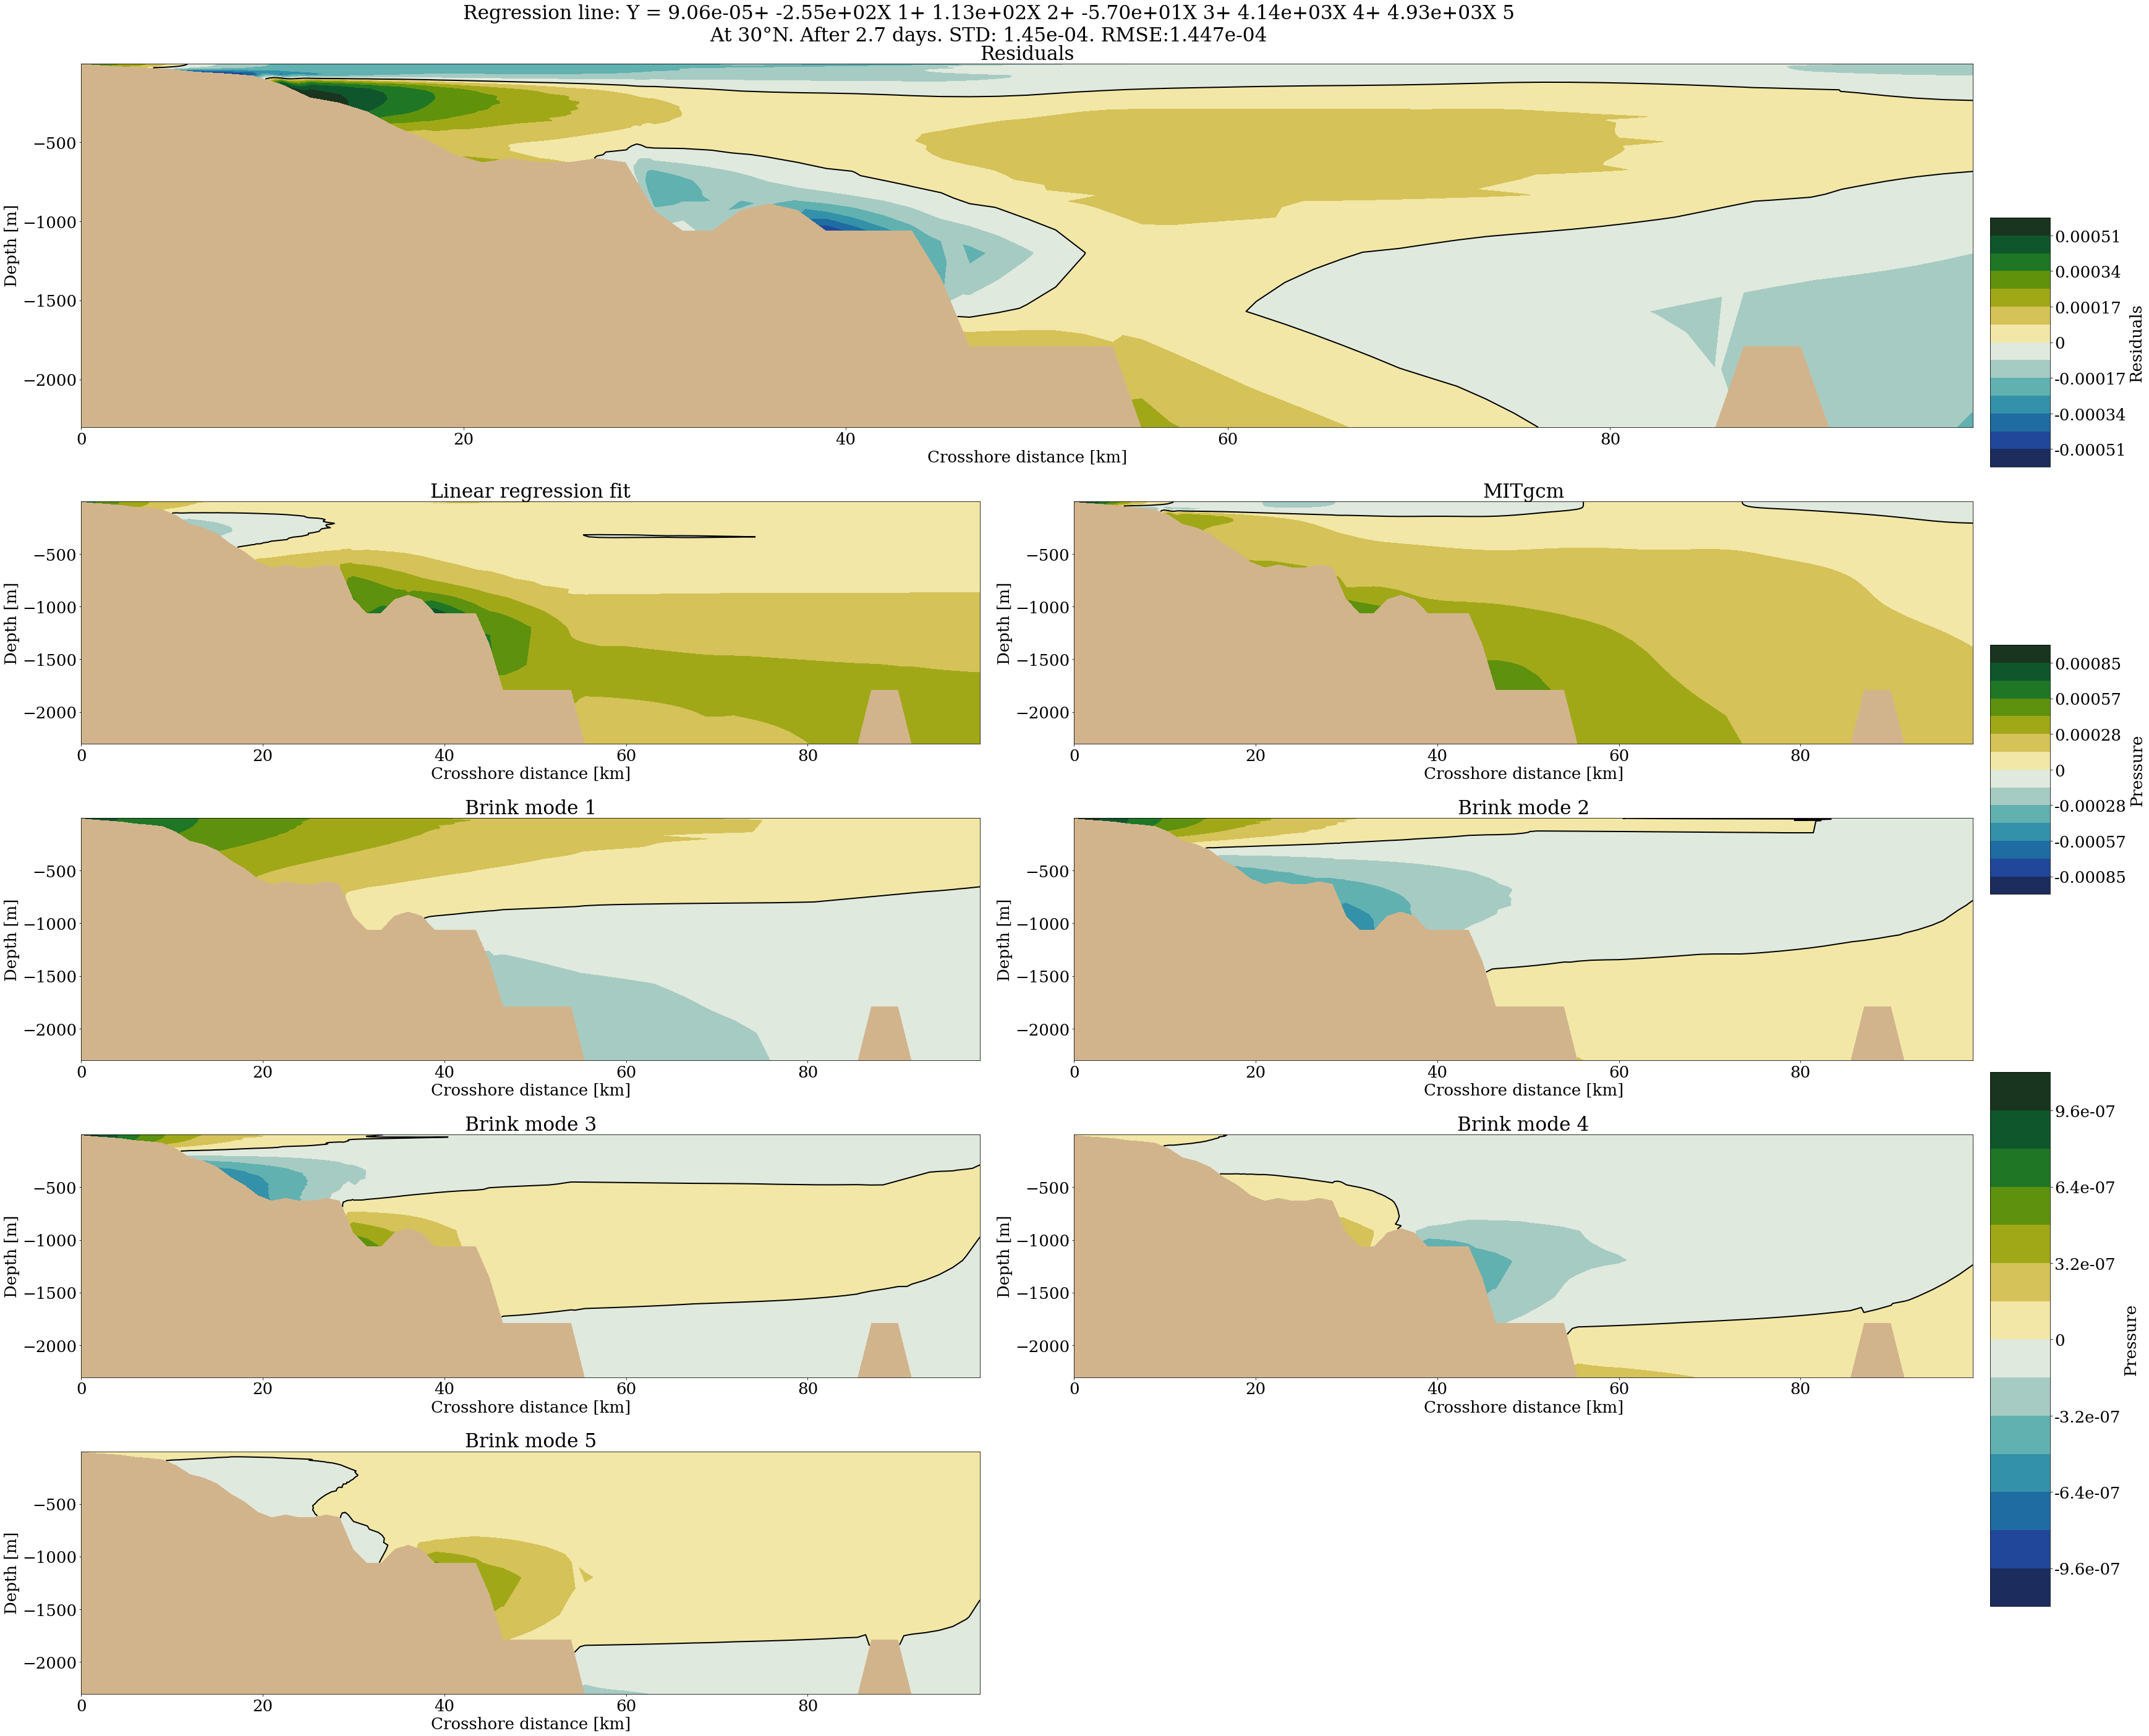

In [78]:
ind=220
lat=30
t=100
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,valbrinkout,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,times,BETAp,FITp,t,RMSE[t])

### At 30.7° N

### Filtered

<Figure size 3240x2880 with 0 Axes>

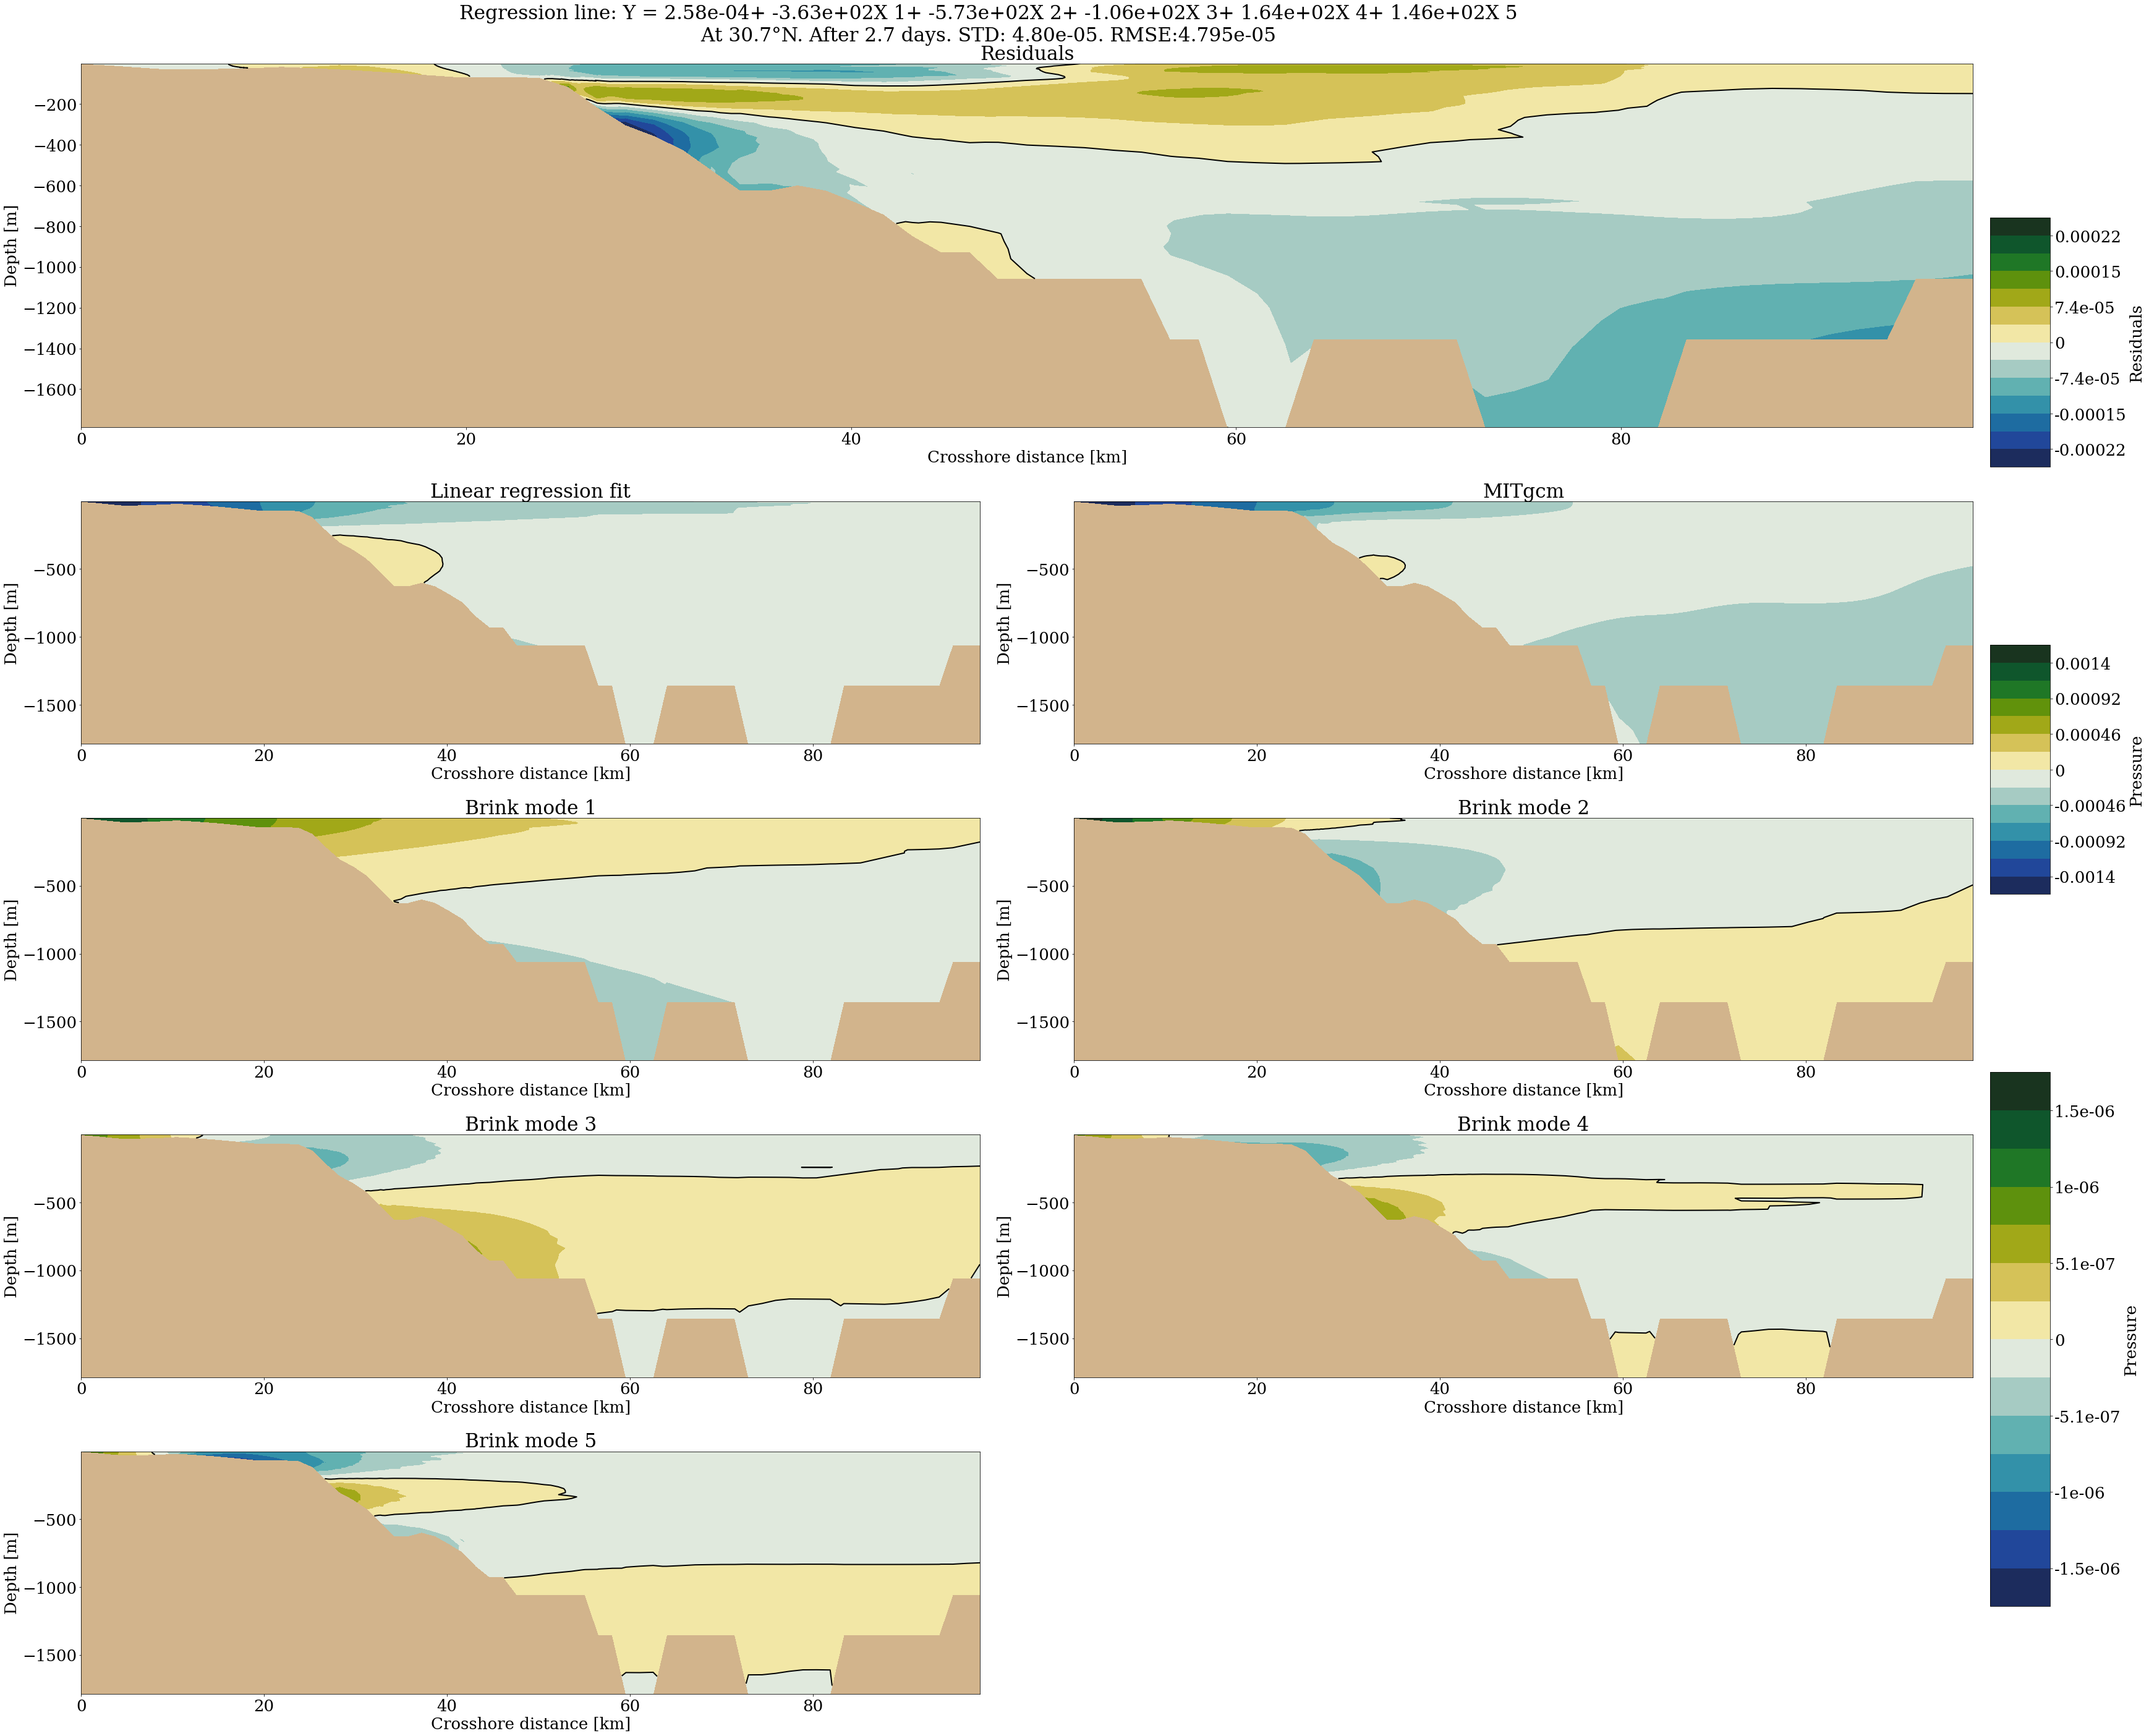

In [111]:
ind=220+50
lat=30.7
t=50
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,valbrinkout,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,timesf.values,BETAp,FITp,t,RMSE[t])

### Unfiltered

<Figure size 3240x2880 with 0 Axes>

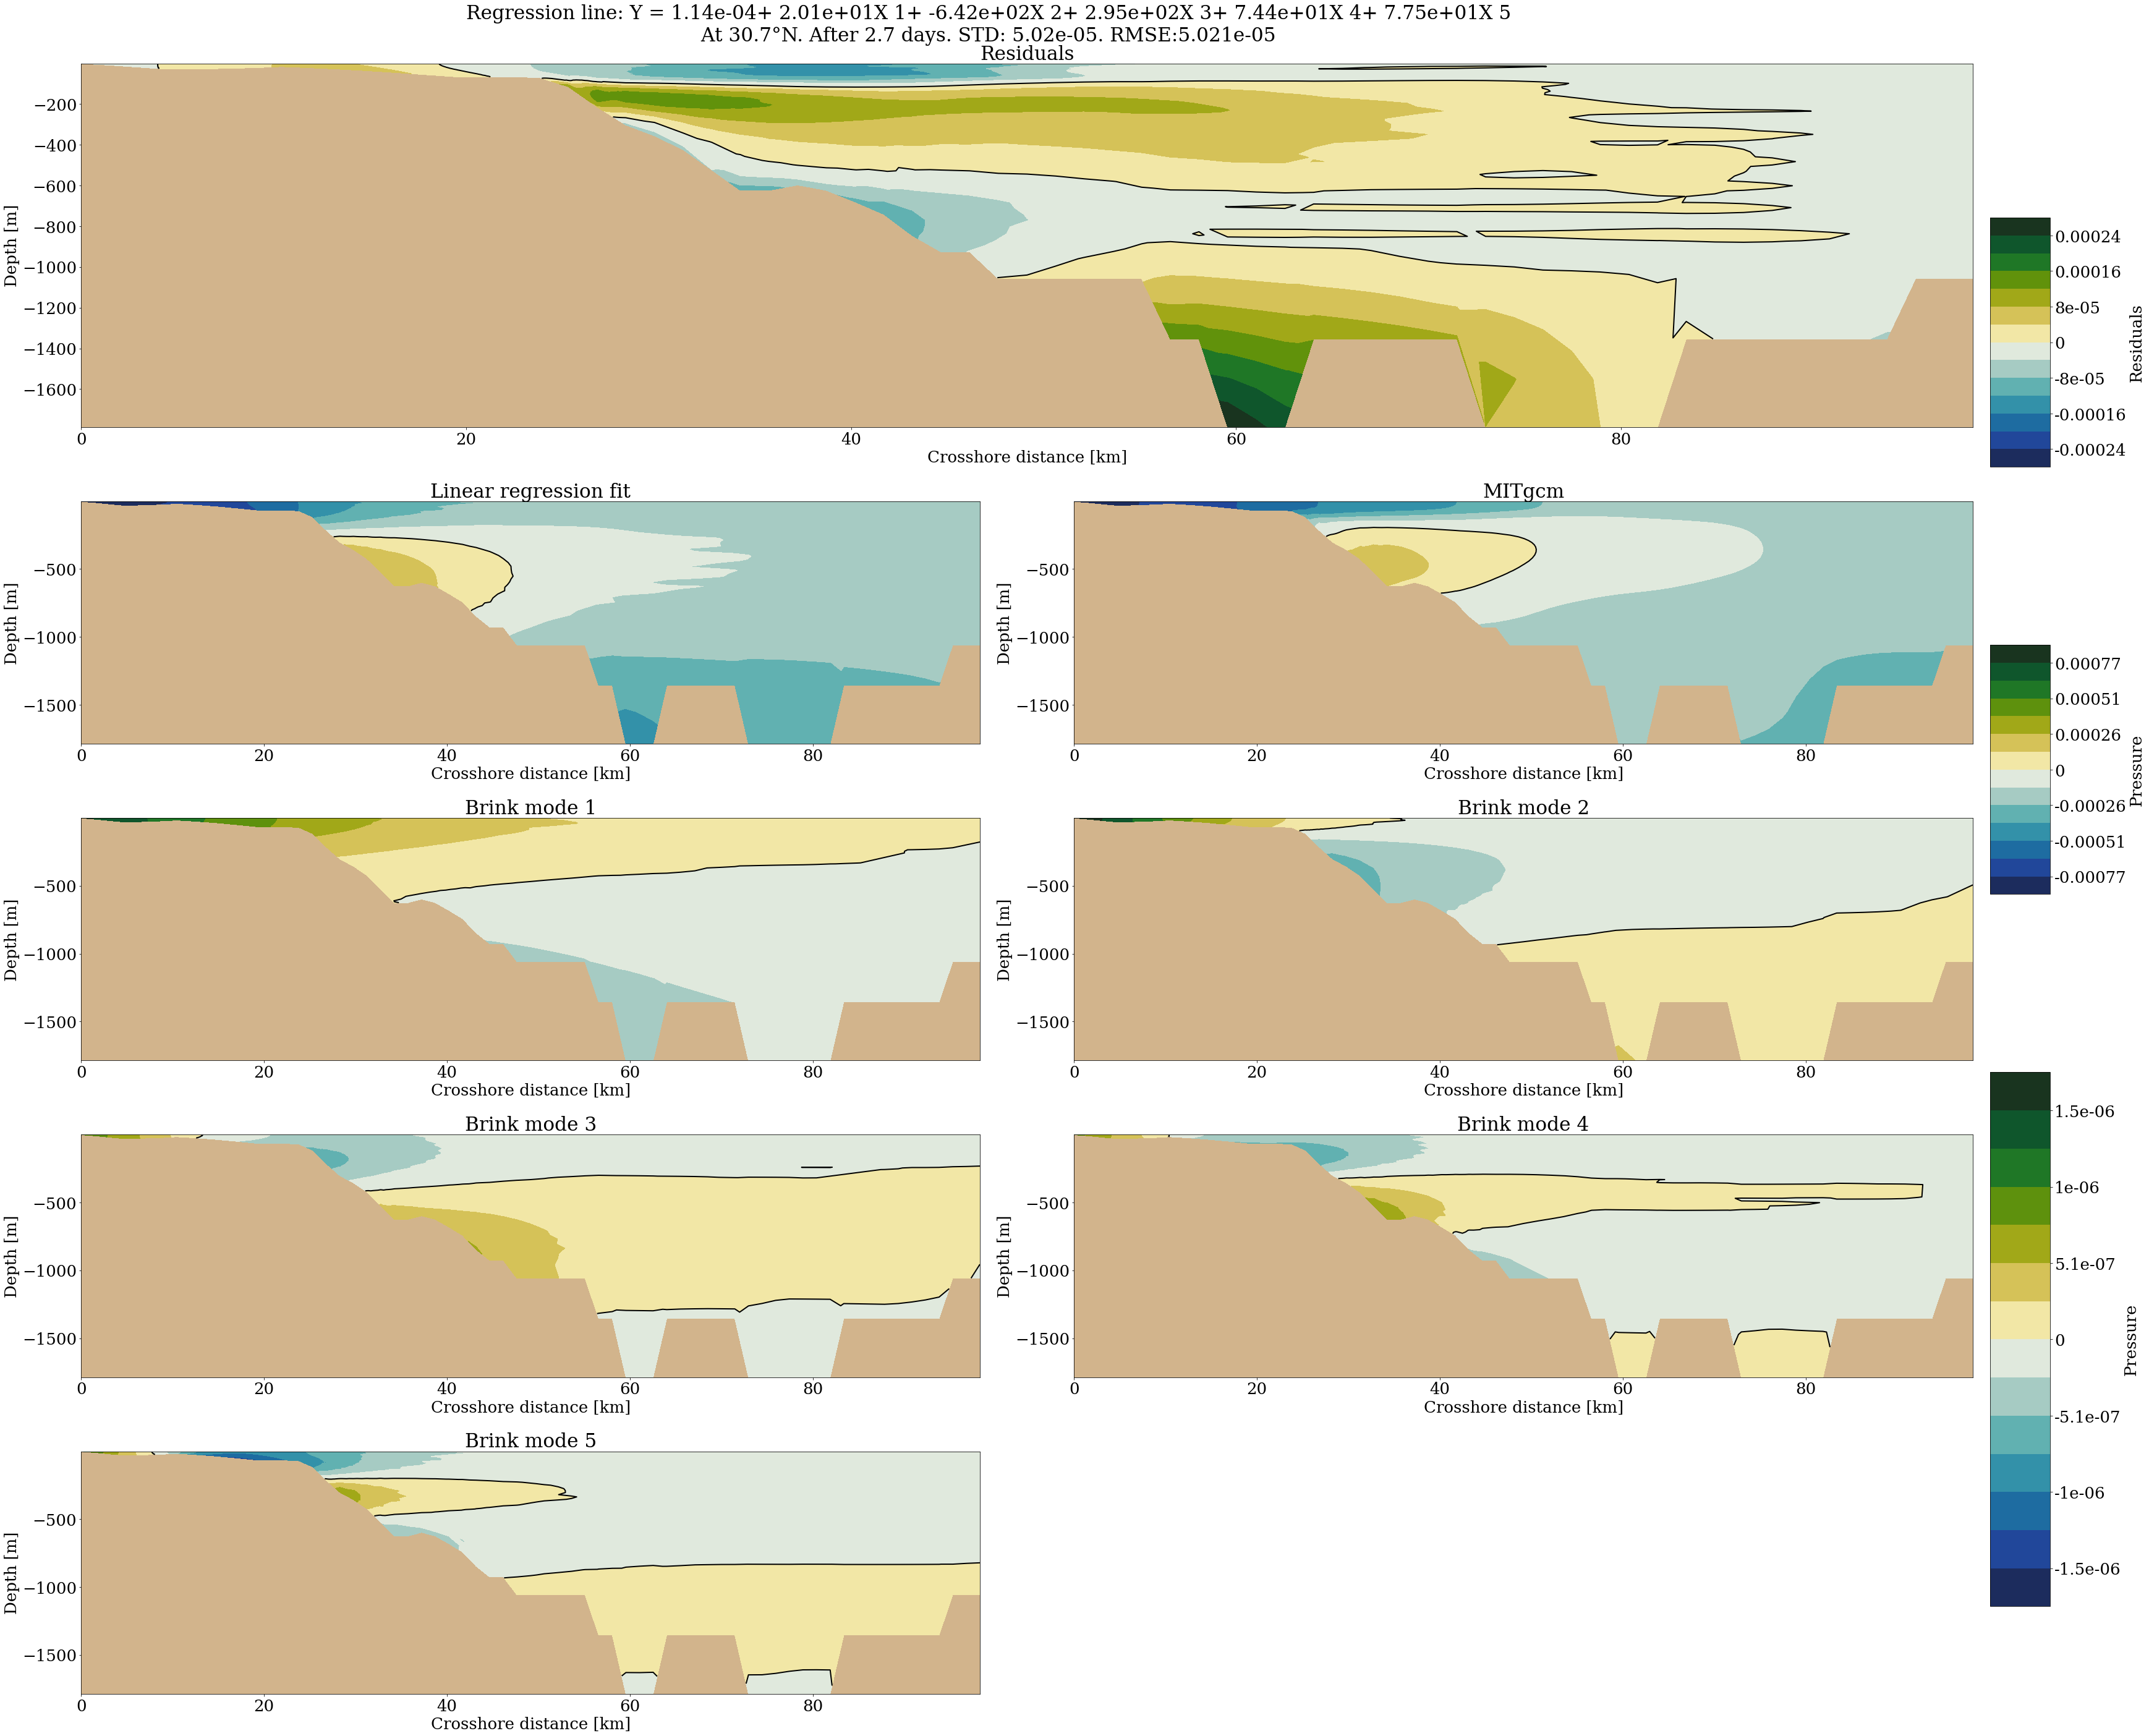

In [104]:
ind=220+50
lat=30.7
t=100
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,valbrinkout,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,times,BETAp,FITp,t,RMSE[t])

### At 31.4° N

### Filtered

<Figure size 3240x2880 with 0 Axes>

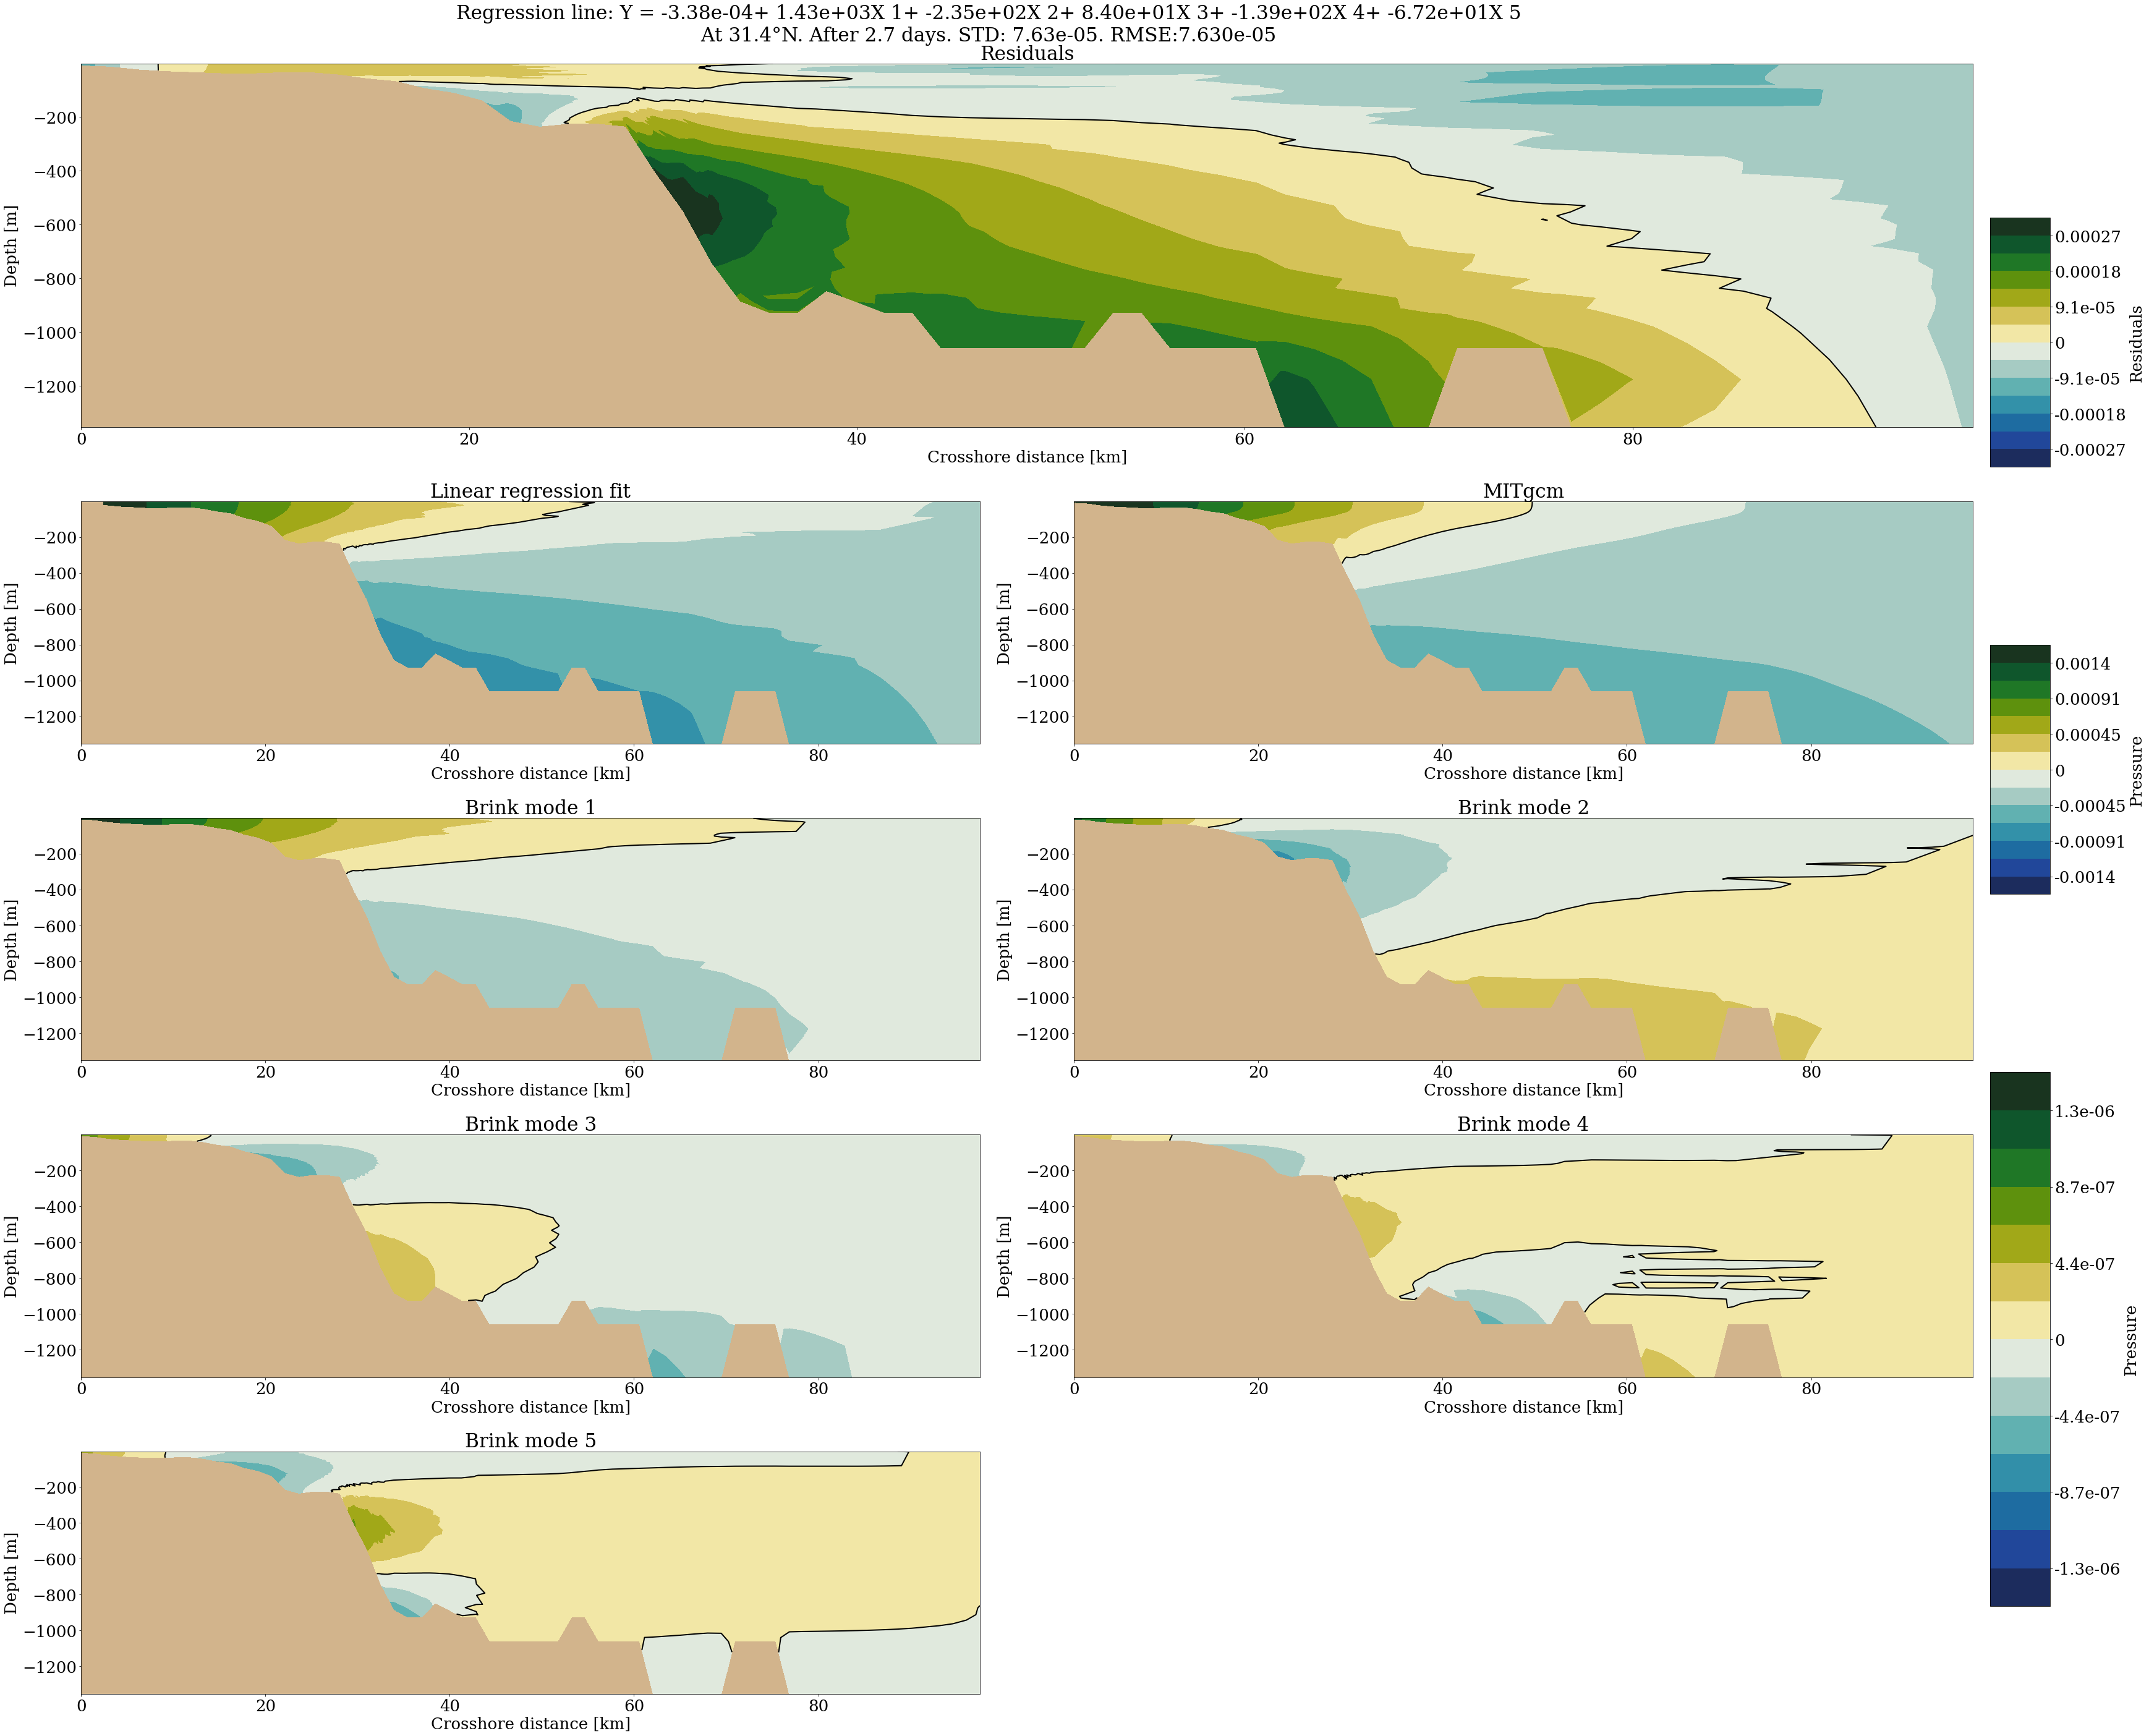

In [126]:
ind=220+100
lat=31.4
t=50
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,valbrinkout,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,timesf.values,BETAp,FITp,t,RMSE[t])

### Unfiltered

<Figure size 3240x2880 with 0 Axes>

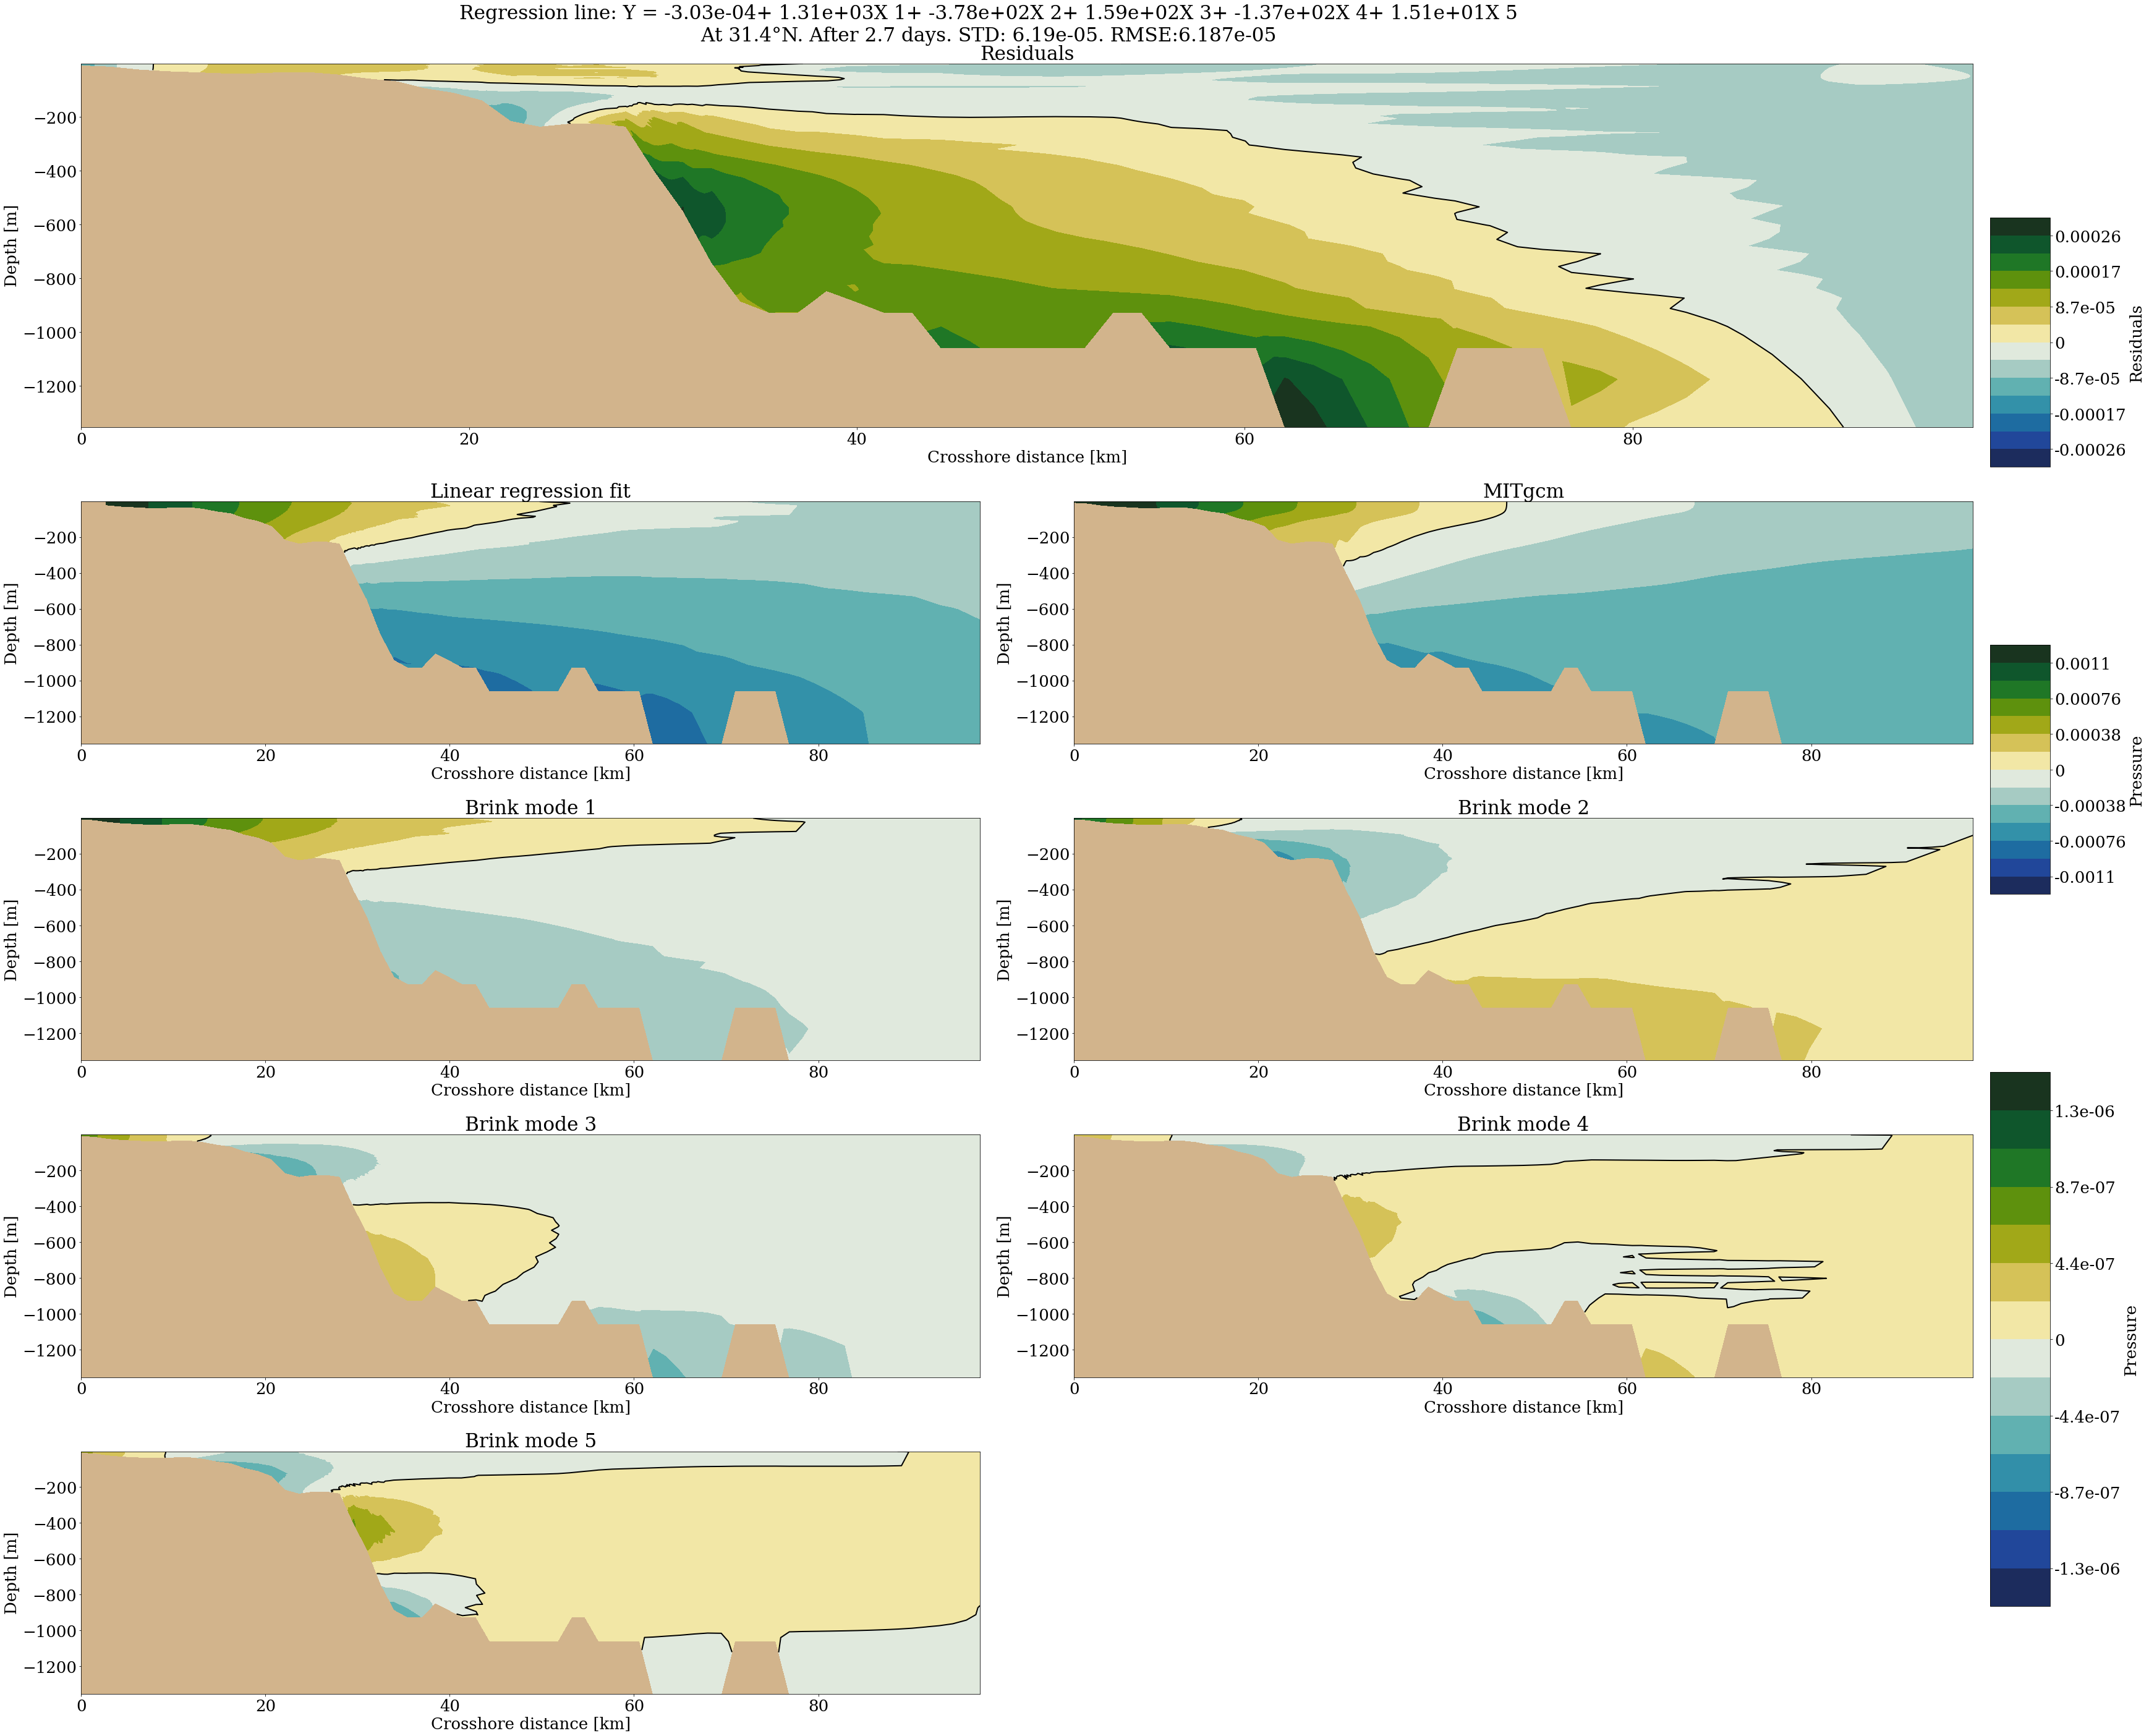

In [132]:
ind=220+100
lat=31.4
t=100
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,valbrinkout,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,times,BETAp,FITp,t,RMSE[t])

### At 32° N

### Filtered

<Figure size 3240x2880 with 0 Axes>

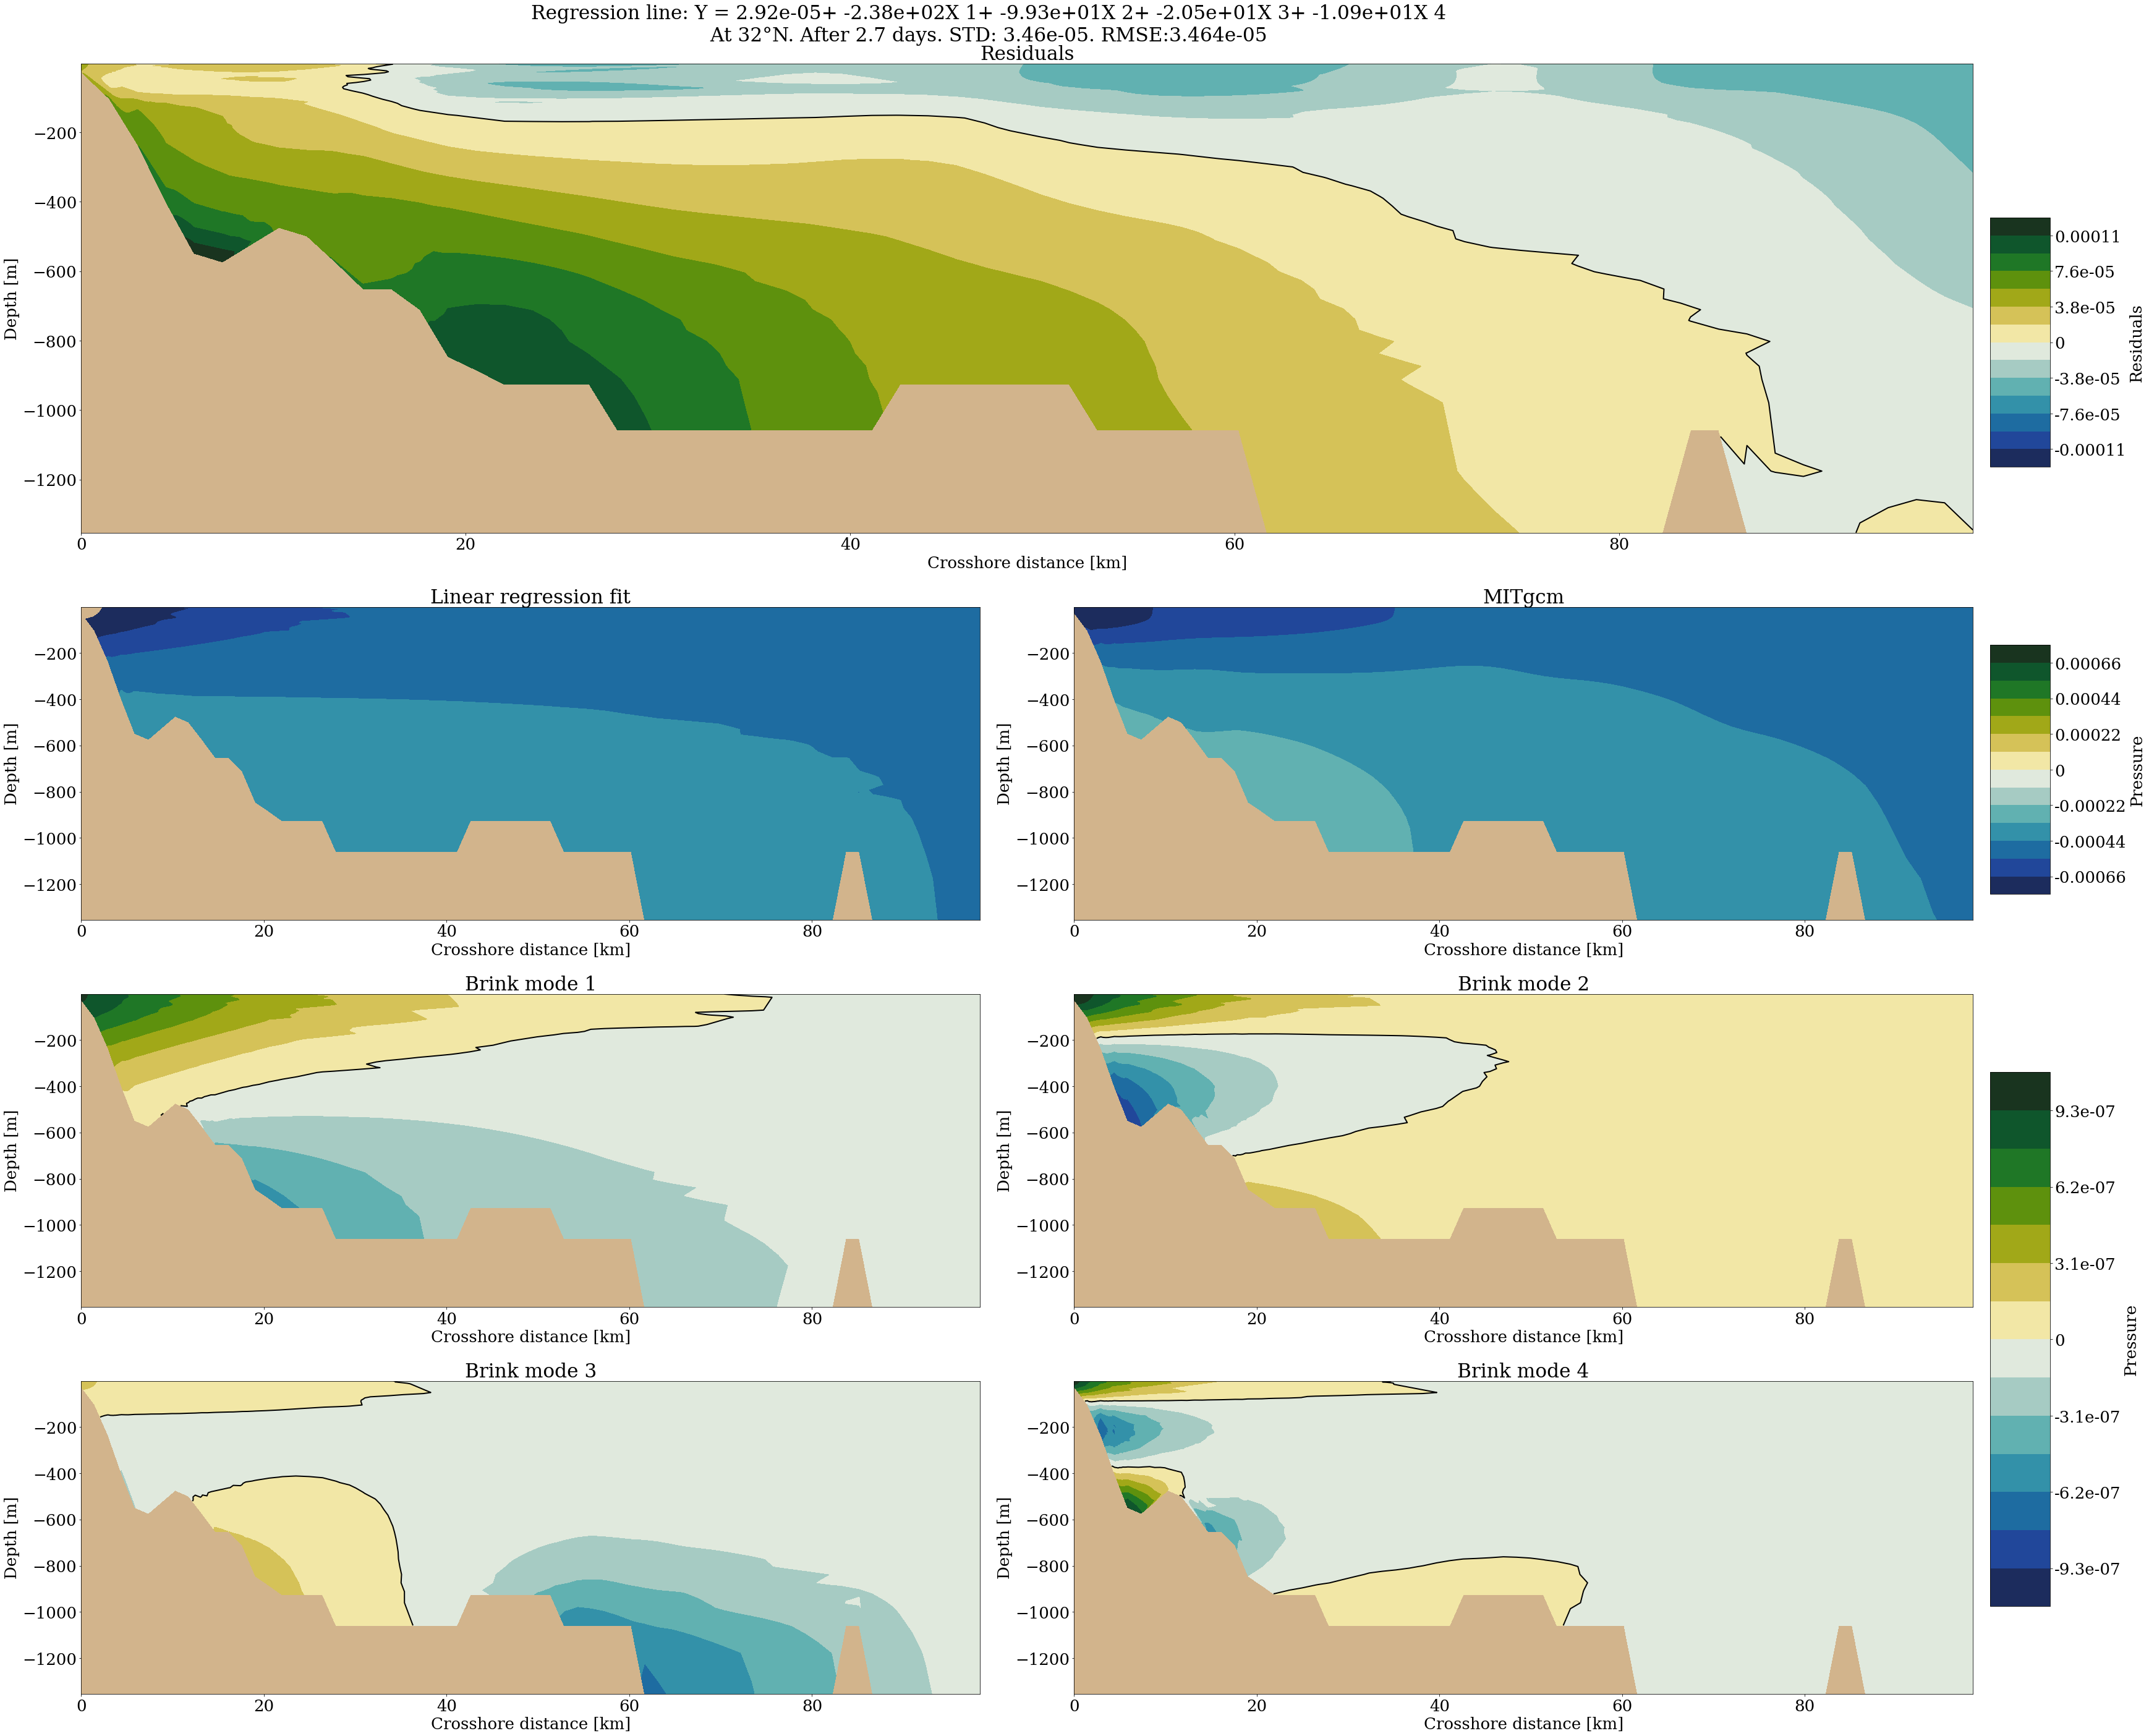

In [151]:
ind=220+150
lat=32
t=50
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,valbrinkout,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,timesf.values,BETAp,FITp,t,RMSE[t])

### Unfiltered

<Figure size 3240x2880 with 0 Axes>

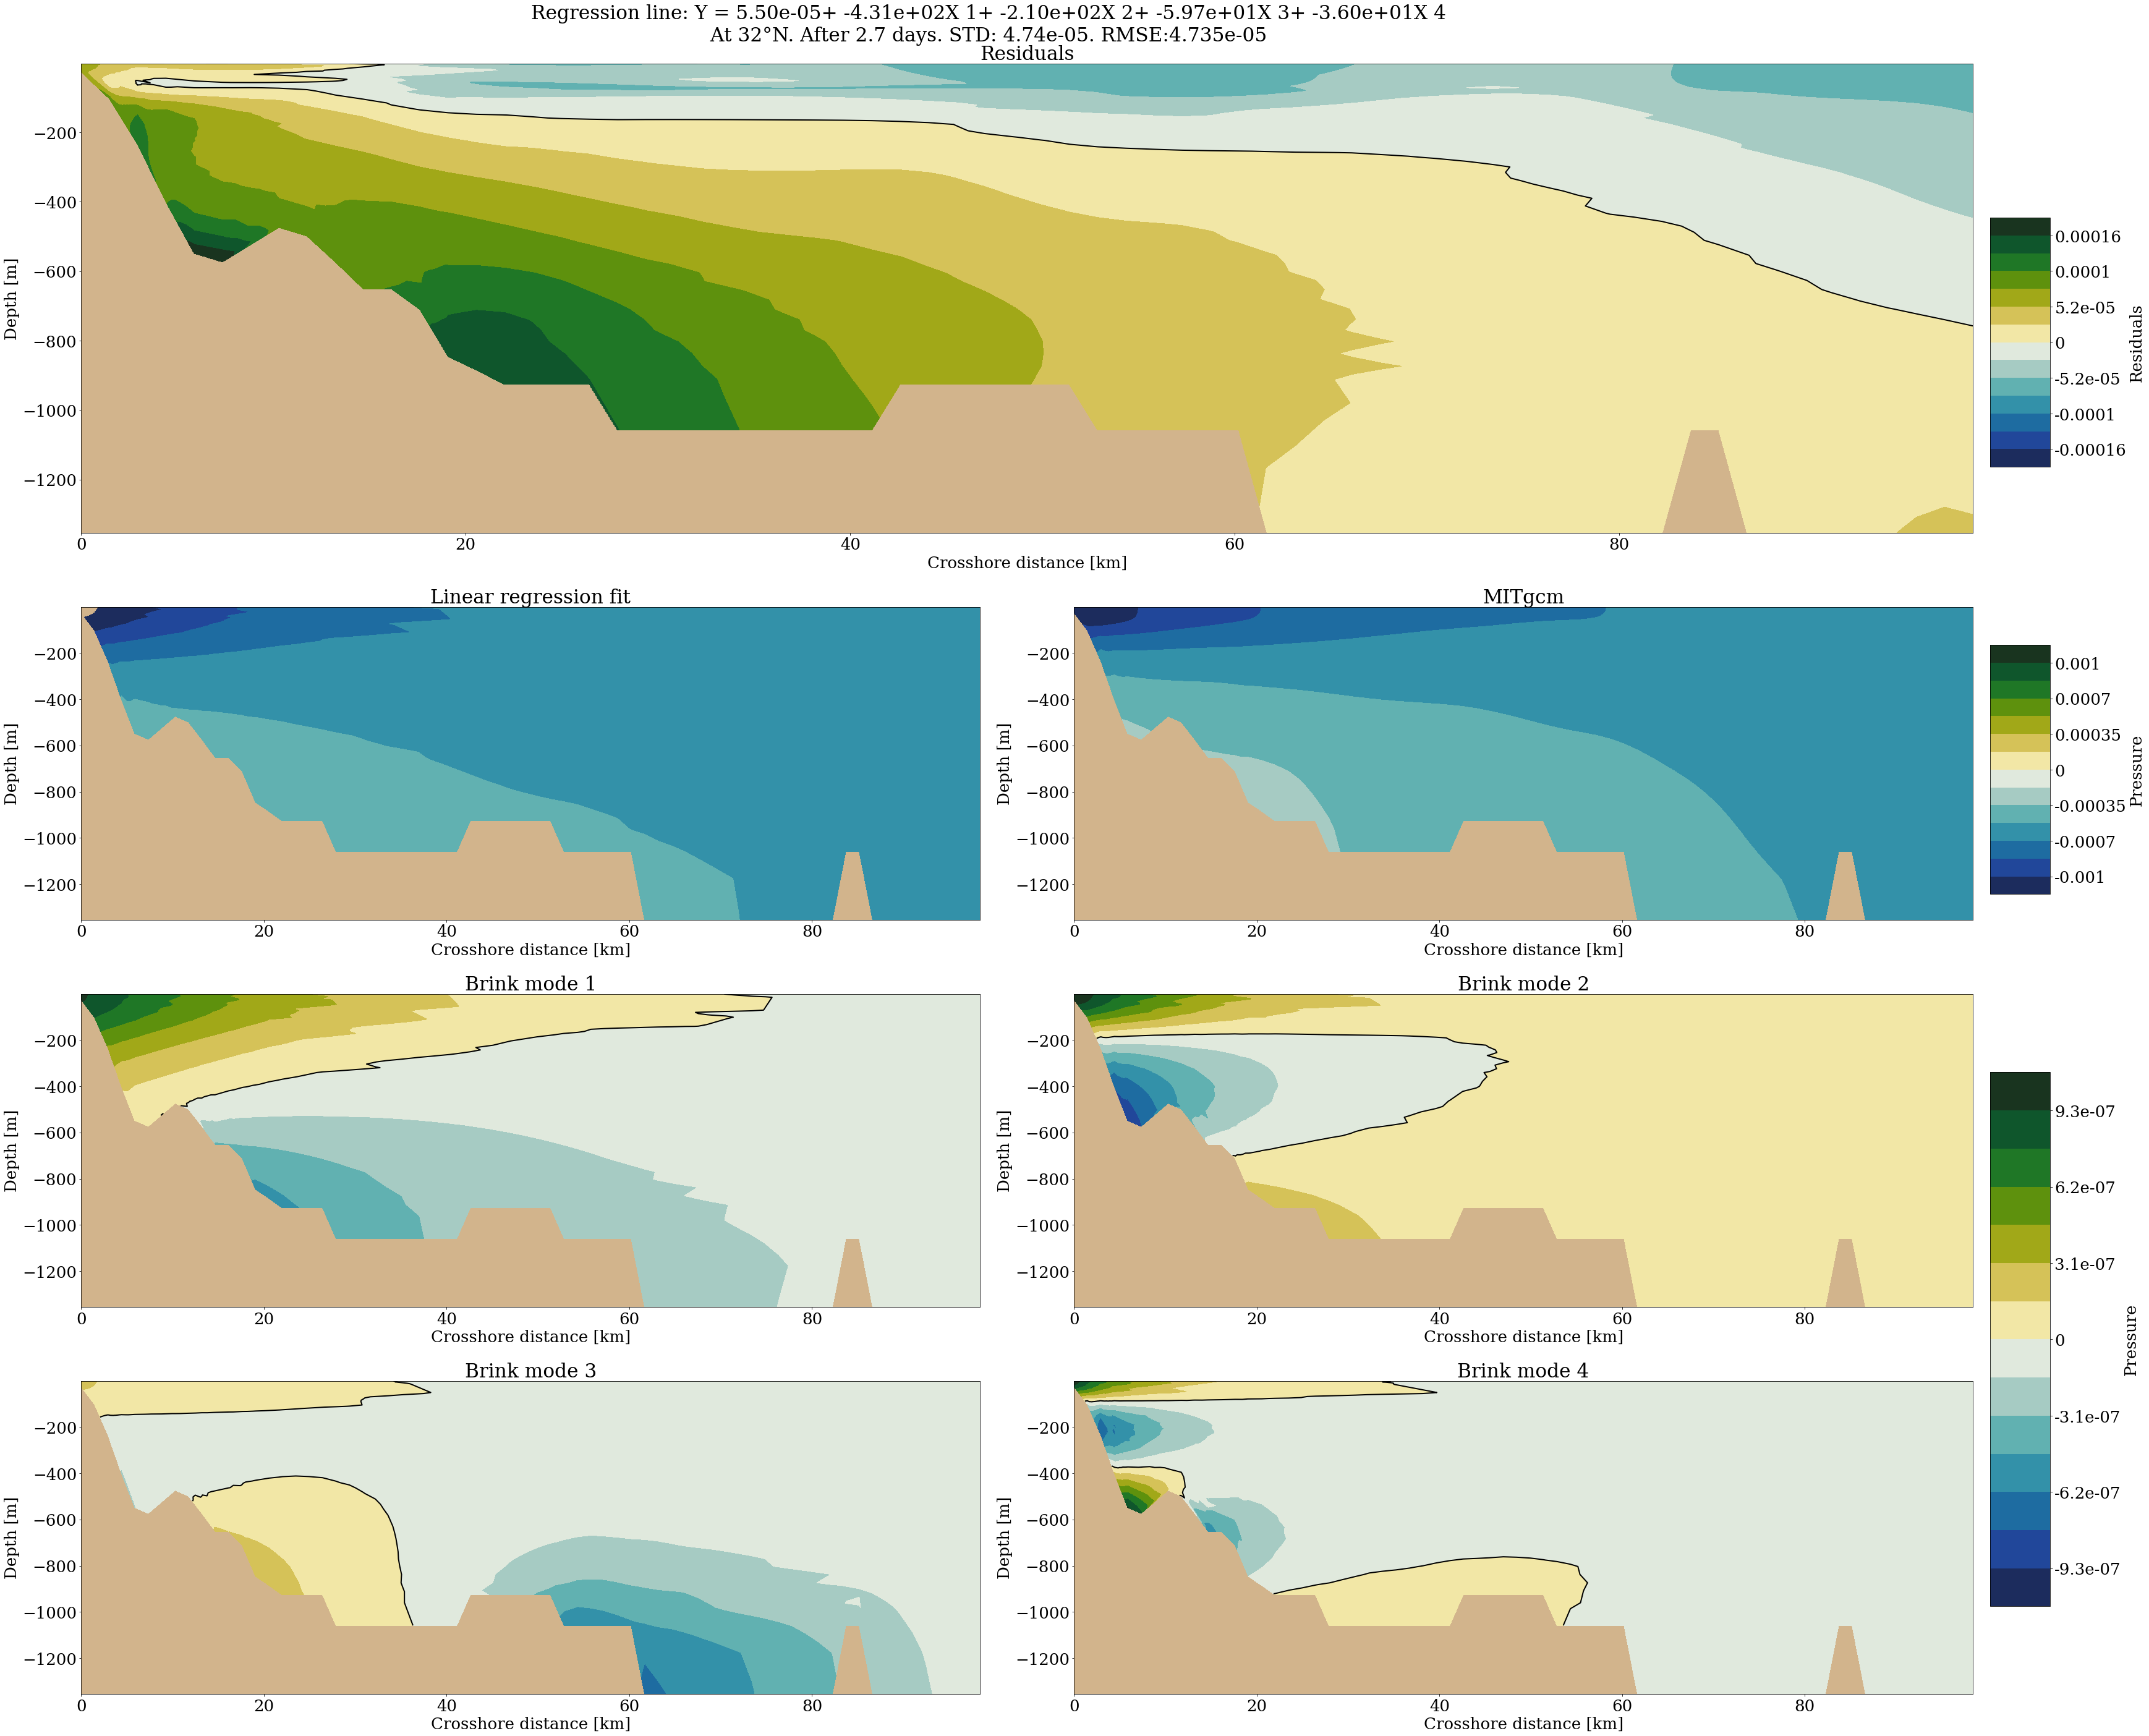

In [145]:
ind=220+150
lat=32
t=100
fig = plt.figure()
LINREGplot(fig,VALMITp,VALFITp,valbrinkout,dsw,ind,lat,grid_Z,grid_X,
               dist,Z,times,BETAp,FITp,t,RMSE[t])

## Change over time

In [153]:
ds30=xr.open_dataset('Crossects/LinReg30FILT.nc')
ds307=xr.open_dataset('Crossects/LinReg307FILT.nc')
ds314=xr.open_dataset('Crossects/LinReg314FILT.nc')
ds32=xr.open_dataset('Crossects/LinReg32FILT.nc')

In [154]:
beta30=ds30.betas.values
beta307=ds307.betas.values
beta314=ds314.betas.values
beta32=ds32.betas.values

In [155]:
DOMmode30=np.zeros(len(beta30[:,1]))
DOMmode307=np.zeros(len(beta307[:,1]))
DOMmode314=np.zeros(len(beta314[:,1]))
DOMmode32=np.zeros(len(beta32[:,1]))
for l in np.arange(len(beta30[:,1])):
    DOMmode30[l]=np.argmax(abs(beta30[l,:]))
    DOMmode307[l]=np.argmax(abs(beta307[l,:]))
    DOMmode314[l]=np.argmax(abs(beta314[l,:]))
    DOMmode32[l]=np.argmax(abs(beta32[l,:]))

In [175]:
colors=['b','g','r','k','m' ,'c','y','brown','lime','fuchsia']

In [172]:
len(beta32[0,:])

5

Text(-27, 8000, '32°N')

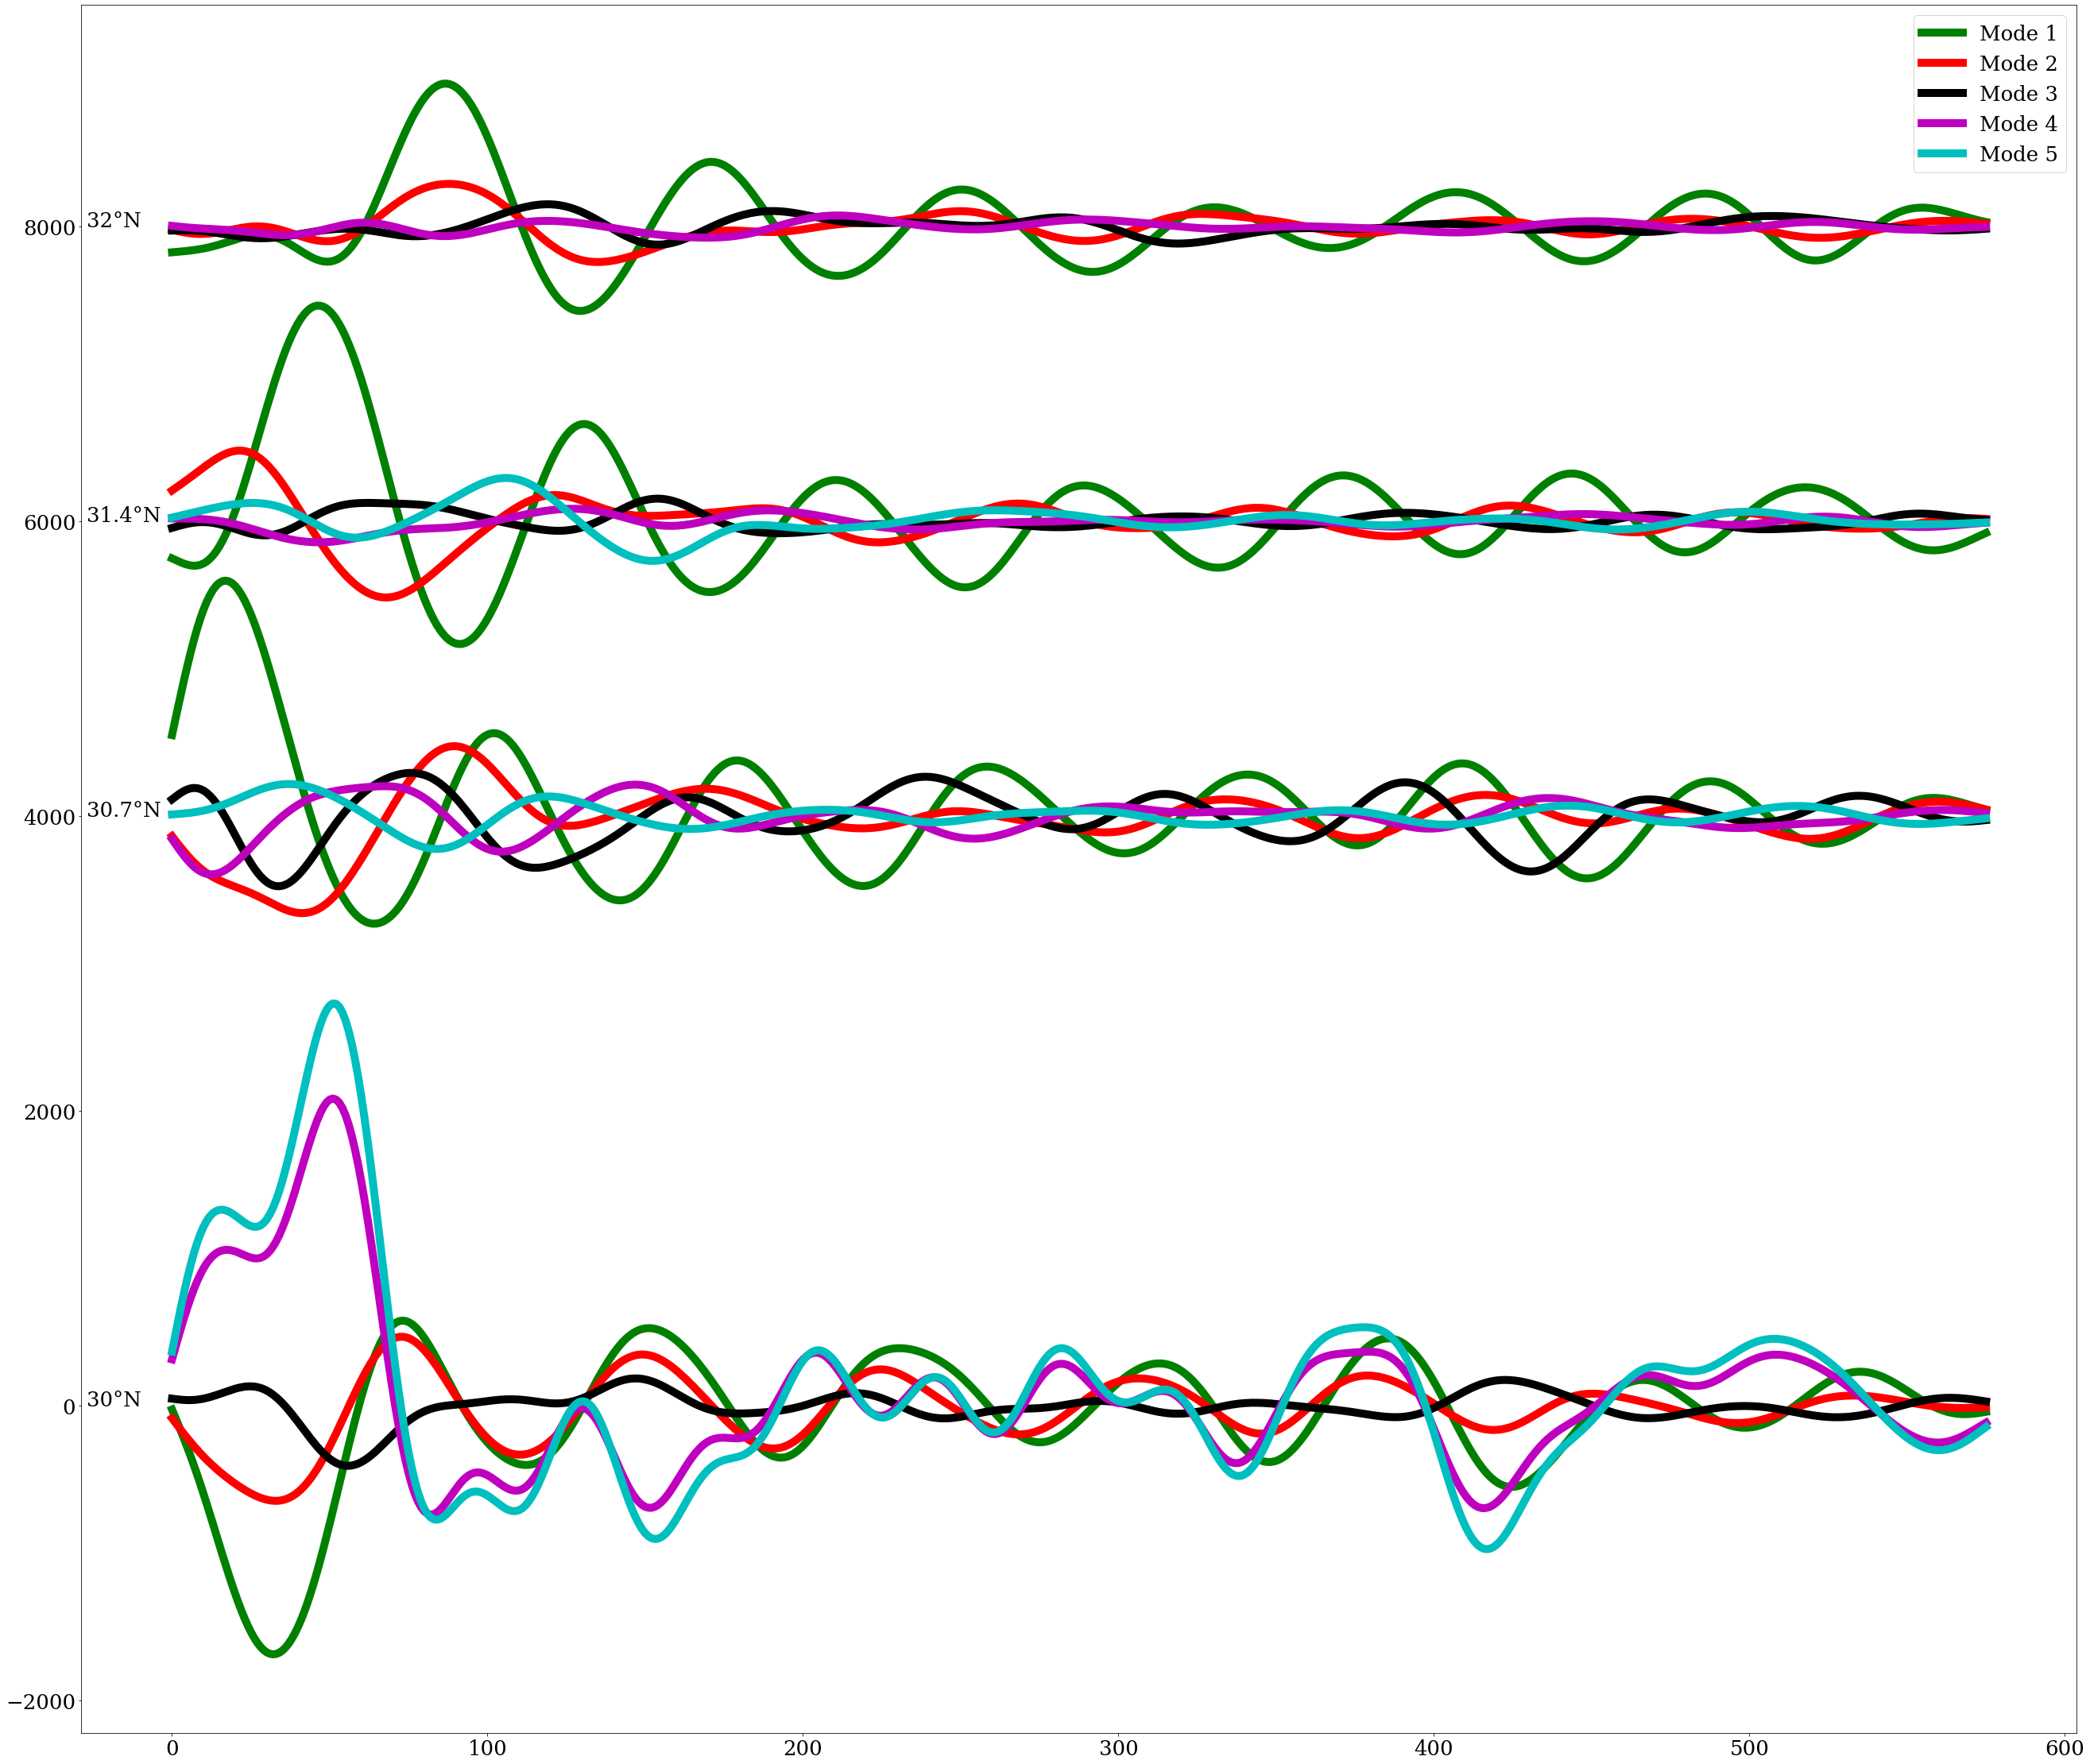

In [188]:
fig,ax=plt.subplots()
for i in np.arange(1,6,1):
    plt.plot(beta30[:,i], color=colors[i],label=f'Mode {i}', linewidth=10)
    plt.plot(beta307[:,i]+4000, color=colors[i], linewidth=10)
    plt.plot(beta314[:,i]+6000, color=colors[i], linewidth=10)
    if i<=4:
        plt.plot(beta32[:,i]+8000, color=colors[i], linewidth=10)
#plt.set(xlabel='Time (hrs)', ylabel='Mode nr')
plt.legend()
plt.annotate('30°N', (-27,0))
plt.annotate('30.7°N', (-27,4000))
plt.annotate('31.4°N', (-27,6000))
plt.annotate('32°N', (-27,8000))
